# Simple tutorial of TMDB Box Office Competition using XGB, LGB and CatGB

In this Kernel we will see how to perform feature engineering (transform features, handle missing values and add new features) and model selection and validation for the competition "TMDB Box Office" in a very simple way.

I am also very grateful to user Serigne for its Kernel about the House Prices competition: it taught me a lot and I really recommend it to you.

# Part 0: Import libraries and read databases

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm,skew
import ast
from sklearn.preprocessing import MultiLabelBinarizer,LabelEncoder
from scipy.special import boxcox1p,inv_boxcox1p,boxcox
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin,clone
from sklearn.metrics import mean_squared_log_error

/anaconda2/lib/python2.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

print "Shape of train set = {}, shape of test set = {}".format(train.shape,test.shape)

Shape of train set = (3000, 23), shape of test set = (4398, 22)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

# Part 1: Feature Engineering

Notice that there are many non-numeric features, which we will want to transform into dummy variables. In order to do so we will need to cancatenate *train* and *test* datasets into a unique dataset *df*.

We will also drop the feature *id*, since it is useless for the analysis.

In [4]:
test.index=test.index+3000

df=pd.concat([train.drop("revenue",axis=1),test]).drop("id", axis=1)
y_train=train["revenue"]
print "Shape of df = {}, shape of y_train = {}".format(df.shape,y_train.shape)

Shape of df = (7398, 21), shape of y_train = (3000,)


## Part 1.1: Modify the target variable

We want our model to perform as good as possible and in order to do so the target variable of *y_train* must be as close as possible to the normal distribution (and its probability plot as close as linear as possible). 

We will thus check which power transformation of boxcox fulfills this task better.

In [5]:
def visualize_distribution(y):
    sns.distplot(y,fit=norm)
    mu,sigma=norm.fit(y)
    plt.legend(["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})".format(mu,sigma)])
    plt.title("Distribution of revenue")
    plt.ylabel("Frequency")
    plt.show()
    
    
def visualize_probplot(y):
    stats.probplot(y,plot=plt)
    plt.show()

/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


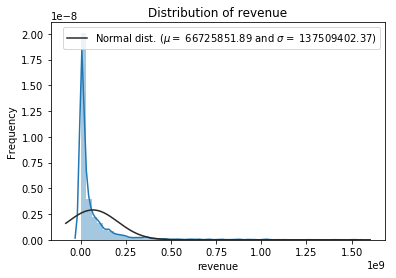

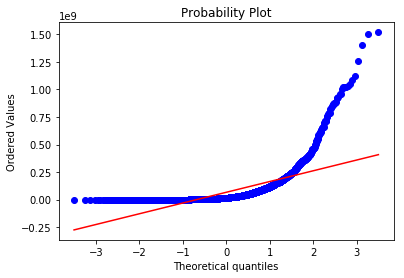

In [6]:
visualize_distribution(y_train)
visualize_probplot(y_train)

It turns out that the boxcox transformation with coefficient 0.2 is the one which makes the probability plot closer to linear: we thus apply it to *y_train*.

In [7]:
y_train=boxcox1p(y_train,0.2)

**Of course, before submitting the prediction we will need to remember to perform the inverse transformation!**

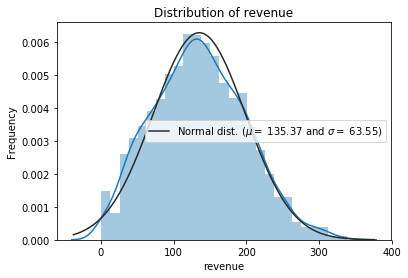

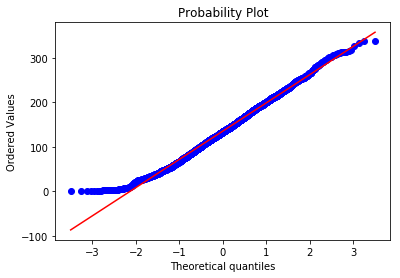

In [8]:
visualize_distribution(y_train)
visualize_probplot(y_train)

## Part 1.2: Fix the features with JSON-like formatting

Some features are in a JSON-like format and will need to be converted to dictionaries or lists before being used. We will do it with *ast.literal_eval()*.

The features of *features_to_fix* will be transformed in lists, since we will only need the informations regarding the name.

In [9]:
features_to_fix=["belongs_to_collection", "genres", "production_companies", "production_countries",\
                 "Keywords"]

for feature in features_to_fix:
    df.loc[df[feature].notnull(),feature]=\
    df.loc[df[feature].notnull(),feature].apply(lambda x : ast.literal_eval(x))\
    .apply(lambda x : [y["name"] for y in x])

Instead, the features *cast* and *crew* will be transformed in dictionaries

In [10]:
df.loc[df["cast"].notnull(),"cast"]=df.loc[df["cast"].notnull(),"cast"].apply(lambda x : ast.literal_eval(x))
df.loc[df["crew"].notnull(),"crew"]=df.loc[df["crew"].notnull(),"crew"].apply(lambda x : ast.literal_eval(x))

## Part 1.3: Create new features and drop some useless ones

Now it is time to create new useful features for our model to use

**New features involving lengths**

In [11]:
df["cast_len"] = df.loc[df["cast"].notnull(),"cast"].apply(lambda x : len(x))
df["crew_len"] = df.loc[df["crew"].notnull(),"crew"].apply(lambda x : len(x))

df["production_companies_len"]=df.loc[df["production_companies"].notnull(),"production_companies"]\
.apply(lambda x : len(x))

df["production_countries_len"]=df.loc[df["production_countries"].notnull(),"production_countries"]\
.apply(lambda x : len(x))

df["Keywords_len"]=df.loc[df["Keywords"].notnull(),"Keywords"].apply(lambda x : len(x))
df["genres_len"]=df.loc[df["genres"].notnull(),"genres"].apply(lambda x : len(x))

df['original_title_letter_count'] = df['original_title'].str.len() 
df['original_title_word_count'] = df['original_title'].str.split().str.len() 
df['title_word_count'] = df['title'].str.split().str.len()
df['overview_word_count'] = df['overview'].str.split().str.len()
df['tagline_word_count'] = df['tagline'].str.split().str.len()

**Features underlining important characteristics of films**

In [12]:
df.loc[df["homepage"].notnull(),"homepage"]=1
df["homepage"]=df["homepage"].fillna(0)  # Note that we only need to know if the film has a webpage or not!

df["in_collection"]=1
df.loc[df["belongs_to_collection"].isnull(),"in_collection"]=0

df["has_tagline"]=1
df.loc[df["tagline"].isnull(),"has_tagline"]=0

df["title_different"]=1
df.loc[df["title"]==df["original_title"],"title_different"]=0

df["isReleased"]=1
df.loc[df["status"]!="Released","isReleased"]=0

**New features from** *release_date*

In [13]:
release_date=pd.to_datetime(df["release_date"])
df["release_year"]=release_date.dt.year
df["release_month"]=release_date.dt.month
df["release_day"]=release_date.dt.day
df["release_wd"]=release_date.dt.dayofweek
df["release_quarter"]=release_date.dt.quarter

**Modify** *cast* **and** *crew*

For each film we only want to consider the six most important actors (*order* is the order of importance in ascending order starting from 0)

In [14]:
df.loc[df["cast"].notnull(),"cast"]=df.loc[df["cast"].notnull(),"cast"]\
.apply(lambda x : [y["name"] for y in x if y["order"]<6]) 

From *crew* we create new features *Director*, *Producer* and *Executive Producer*

In [15]:
df["Director"]=[[] for i in range(df.shape[0])]
df["Producer"]=[[] for i in range(df.shape[0])]
df["Executive Producer"]=[[] for i in range(df.shape[0])]

df["Director"]=df.loc[df["crew"].notnull(),"crew"]\
.apply(lambda x : [y["name"] for y in x if y["job"]=="Director"])

df["Producer"]=df.loc[df["crew"].notnull(),"crew"]\
.apply(lambda x : [y["name"] for y in x if y["job"]=="Producer"])

df["Executive Producer"]=df.loc[df["crew"].notnull(),"crew"]\
.apply(lambda x : [y["name"] for y in x if y["job"]=="Executive Producer"])

**Now it is very important to delete all useless features which will not be used in the analysis**

In [16]:
df=df.drop(["imdb_id","original_title","overview","poster_path","tagline","status","title",\
           "spoken_languages","release_date","crew"],axis=1)

## Part 1.4: Handle missing values and add even more new features

First of all let's print the list of percentages of missing values in descending order

In [17]:
mis_val=((df.isnull().sum()/df.shape[0])*100).sort_values(ascending=False)
mis_val=mis_val.drop(mis_val[mis_val==0].index)
print mis_val

belongs_to_collection       79.981076
tagline_word_count          19.735064
Keywords                     9.042985
Keywords_len                 9.042985
production_companies         5.596107
production_companies_len     5.596107
production_countries         2.122195
production_countries_len     2.122195
crew_len                     0.513652
Producer                     0.513652
Executive Producer           0.513652
Director                     0.513652
cast_len                     0.351446
cast                         0.351446
genres                       0.310895
genres_len                   0.310895
overview_word_count          0.297378
runtime                      0.081103
title_word_count             0.040552
release_year                 0.013517
release_month                0.013517
release_day                  0.013517
release_wd                   0.013517
release_quarter              0.013517
dtype: float64


The features of *to_empty_list* are lists and consequently their missing values will be replaced with empty lists

In [18]:
to_empty_list=["belongs_to_collection","Keywords","production_companies","production_countries",\
              "Director","Producer","Executive Producer","cast","genres"]

for feature in to_empty_list:
    df[feature] = df[feature].apply(lambda d: d if isinstance(d, list) else [])

The missing values of time and length will be replaced with 0

In [19]:
to_zero=["runtime","release_month","release_year","release_wd","release_quarter","release_day"]+\
["Keywords_len","production_companies_len","production_countries_len","crew_len","cast_len","genres_len",
    "tagline_word_count","overview_word_count","title_word_count"]

for feat in to_zero:
    df[feat]=df[feat].fillna(0)

**Now it is the best time to add new features, since they will not be affected by the missing values of other features**

In [20]:
df['_budget_popularity_ratio'] = df['budget']/df['popularity']
df['_releaseYear_popularity_ratio'] = df['release_year']/df['popularity']
df['_releaseYear_popularity_ratio2'] = df['popularity']/df['release_year']

Finally, we can see there are no missing values!

In [21]:
mis_val=((df.isnull().sum()/df.shape[0])*100).sort_values(ascending=False)
mis_val=mis_val.drop(mis_val[mis_val==0].index)
print mis_val

Series([], dtype: float64)


## Part 1.6: Modify numeric features

As we did in Part 1.1 for the target variable, it is now important to modify the numeric features in order to make them as close as possible to the normal distribution.

First of all let's select the numeric features which has a high skewness

In [22]:
numeric=[feat for feat in df.columns if df[feat].dtype!="object"]

skewness=df[numeric].apply(lambda x : skew(x)).sort_values(ascending=False)
skew=skewness[skewness>2.5]
print skew

_budget_popularity_ratio         85.779254
_releaseYear_popularity_ratio    60.793692
popularity                       19.960329
Keywords_len                      3.123832
production_countries_len          2.990402
budget                            2.891855
cast_len                          2.809725
dtype: float64


/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:943: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)


Let's reduce the  skewness of these features by applying a power transformation

In [23]:
high_skew=skew[skew>10].index
medium_skew=skew[skew<=10].index

for feat in high_skew:
    df[feat]=np.log1p(df[feat])

for feat in medium_skew:
    df[feat]=df[feat]=boxcox1p(df[feat],0.15)

Indeed, we can se the skewness is really improved:

In [24]:
skew=df[skew.index].skew()
print skew

_budget_popularity_ratio        -0.881118
_releaseYear_popularity_ratio    2.603714
popularity                      -0.437615
Keywords_len                    -0.309683
production_countries_len         1.332405
budget                          -0.476944
cast_len                         0.220478
dtype: float64


Finally, let's visualize the distribution of these features

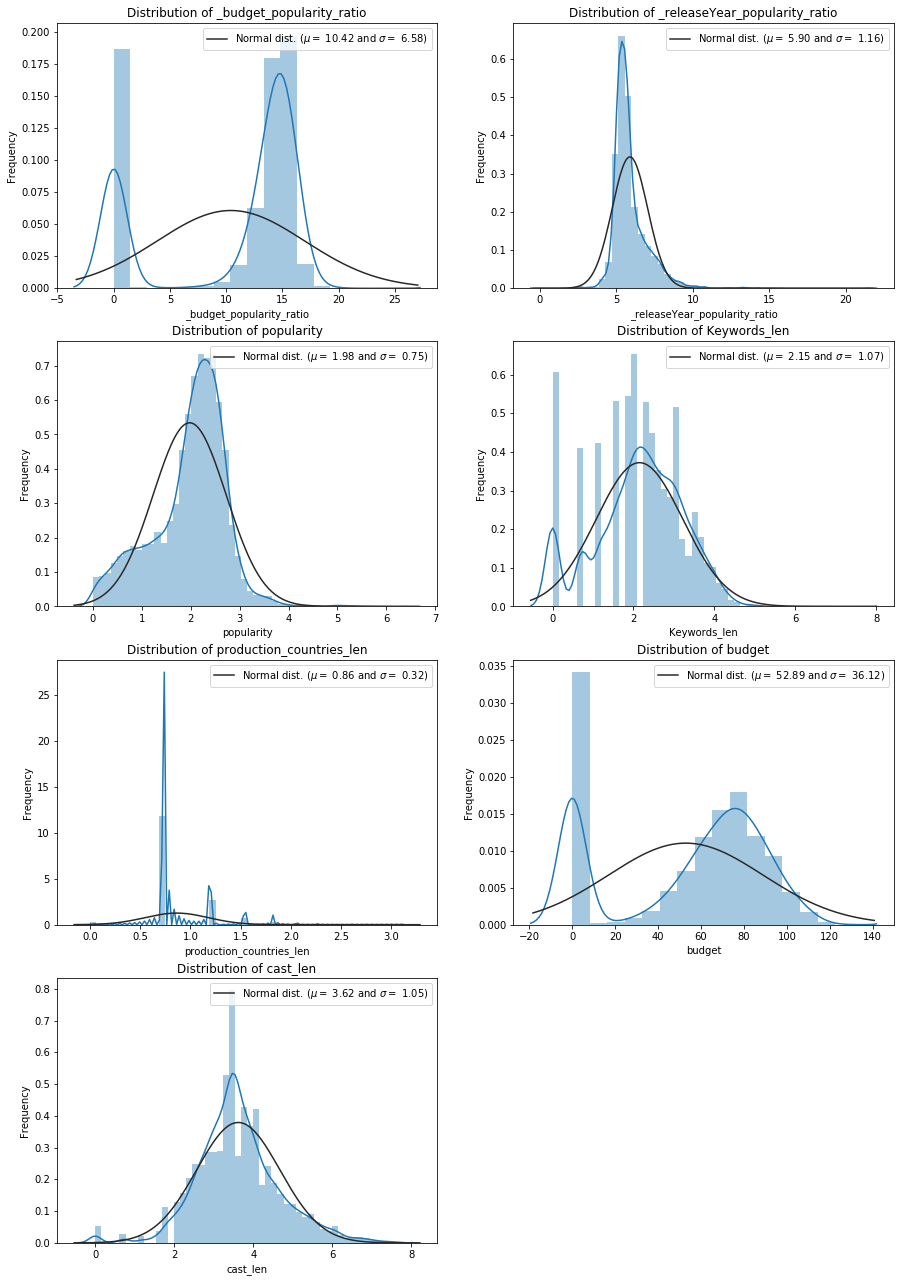

In [25]:
plt.figure(figsize=(15,40))
for i,feat in enumerate(skew.index):
    plt.subplot(7,2,i+1)
    sns.distplot(df[feat],fit=norm)
    mu,sigma=norm.fit(df[feat])
    plt.legend(["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})".format(mu,sigma)])
    plt.title("Distribution of "+feat)
    plt.ylabel("Frequency")
plt.show()

It is also useful to feed the feature *release_year* to the label encoder

In [26]:
lbl=LabelEncoder()
lbl.fit(df["release_year"].values)
df["release_year"]=lbl.transform(df["release_year"].values)

## Get dummy variables and separate train and test set

We are going to get dummy variables from all the features which are not numeric

In [27]:
to_dummy = ["belongs_to_collection","genres","original_language","production_companies","production_countries",\
           "Keywords","cast","Director","Producer","Executive Producer"]

Notice that the entries of the features of the list *to_dummy* are lists: in each feature, for each element of each list we want to get a dummy variable only if such element is "famous" enough, which is if it appears in a sufficient number of lists. In order to do so we use the list *limits*, whose entries are, for each feature, the minimum numbers of appearences which an element must have in order to get a dummy variable

In [28]:
#limits=[4,0,0,35,10,40,10,5,10,12] 
limits=[4,0,0,20,30,30,7,4,9,9] 

for i,feat in enumerate(to_dummy):
    mlb = MultiLabelBinarizer()
    s=df[feat]
    x=pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=df.index)
    y=pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=df.index).sum().sort_values(ascending=False)
    rare_entries=y[y<=limits[i]].index
    x=x.drop(rare_entries,axis=1)
    df=df.drop(feat,axis=1)
    df=pd.concat([df, x], axis=1, sort=False)

In [29]:
print "The final total number of features is {}".format(df.shape[1])

The final total number of features is 2226


Finally, after having obtained all the dummy variables we needed, we can separate *df* back in *train* and *test*

In [30]:
ntrain=train.shape[0]

train=df.iloc[:ntrain,:]
test=df.iloc[ntrain:,:]
print "The shape of train DataFrame is {} and the shape of the test DataFrame is {}".format(train.shape,test.shape)

The shape of train DataFrame is (3000, 2226) and the shape of the test DataFrame is (4398, 2226)


# Part 2: Build the model and make the predictions

In this Kernel we will use XGB,LGBM and CatBoost regressors, since they are the state of the art in prediction of tabular data

In [31]:
model_xgb=xgb.XGBRegressor(max_depth=5,
                           learning_rate=0.1, 
                           n_estimators=2000, 
                           objective='reg:linear', 
                           gamma=1.45, 
                           verbosity=3,
                           subsample=0.7, 
                           colsample_bytree=0.8, 
                           colsample_bylevel=0.50)

In [32]:
model_lgb=lgb.LGBMRegressor(n_estimators=10000, 
                             objective="regression", 
                             metric="rmse", 
                             num_leaves=20, 
                             min_child_samples=100,
                             learning_rate=0.01, 
                             bagging_fraction=0.8, 
                             feature_fraction=0.8, 
                             bagging_frequency=1, 
                             subsample=.9, 
                             colsample_bytree=.9,
                             use_best_model=True)

In [33]:
model_cat = cat.CatBoostRegressor(iterations=10000,learning_rate=0.01,depth=5,eval_metric='RMSE',\
                              colsample_bylevel=0.7,
                              bagging_temperature = 0.2,
                              metric_period = None,
                              early_stopping_rounds=200)


## Part 2.1: Perform cross-validation

Before training the models on the whole *train* DataFrame, it is interesting to perform some cross validation, in order to get an idea of how well the models are performing.

Here the cross validations are commented since they require a lot of time

In [34]:
n_folds=5

def cross_val(model):
    cr_val=np.sqrt(-cross_val_score(model,train.values,y_train.values,scoring="neg_mean_squared_log_error",cv=5))
    return cr_val

In [35]:
#print "\n mean XGB score = {:.3f} with std = {:.3f}".format(cross_val(model_xgb).mean(),cross_val(model_xgb).std())

In [36]:
#print "\n mean LGB score = {:.3f} with std = {:.3f}".format(cross_val(model_lgb).mean(),cross_val(model_lgb).std())

In [37]:
#print "\n mean LGB score = {:.3f} with std = {:.3f}".format(cross_val(model_cat).mean(),cross_val(model_cat).std())

## Part 2.2: Train the models

We train the model on the whole *train* DataFrame and compute the loss function using the function *msle*

In [38]:
def msle(y,y_pred):
    return np.sqrt(mean_squared_log_error(y,y_pred))

In [39]:
ti=time.time()
model_lgb.fit(train.values,y_train)
print "Number of minutes of training of model_lgb = {:.2f}".format((time.time()-ti)/60)

lgb_pred_train=model_lgb.predict(train.values)
print "Mean square logarithmic error of lgb model on whole train = {:.4f}".format(msle(y_train,lgb_pred_train))

Number of minutes of training of model_lgb = 0.33
Mean square logarithmic error of lgb model on whole train = 0.2010


In [40]:
ti=time.time()
model_xgb.fit(train.values,y_train)
print "Number of minutes of training of model_xgb = {:.2f}".format((time.time()-ti)/60)

xgb_pred_train=model_xgb.predict(train.values)
print "Mean square logarithmic error of xgb model on whole train = {:.4f}".format(msle(y_train,xgb_pred_train))

Number of minutes of training of model_xgb = 4.19
Mean square logarithmic error of xgb model on whole train = 0.1048


In [41]:
model_cat.fit(train.values,y_train)

0:	learn: 148.2719051	total: 145ms	remaining: 24m 7s
1:	learn: 147.0020434	total: 216ms	remaining: 17m 58s
2:	learn: 145.7219669	total: 283ms	remaining: 15m 43s
3:	learn: 144.5440230	total: 360ms	remaining: 14m 59s
4:	learn: 143.2688449	total: 435ms	remaining: 14m 30s
5:	learn: 142.0584134	total: 510ms	remaining: 14m 9s
6:	learn: 140.8319570	total: 595ms	remaining: 14m 9s
7:	learn: 139.6469341	total: 668ms	remaining: 13m 53s
8:	learn: 138.4696710	total: 744ms	remaining: 13m 45s
9:	learn: 137.3699851	total: 824ms	remaining: 13m 43s
10:	learn: 136.1941636	total: 892ms	remaining: 13m 29s
11:	learn: 135.0278248	total: 961ms	remaining: 13m 20s
12:	learn: 133.9667233	total: 1.03s	remaining: 13m 15s
13:	learn: 132.8554335	total: 1.1s	remaining: 13m 5s
14:	learn: 131.8187170	total: 1.18s	remaining: 13m 2s
15:	learn: 130.7910016	total: 1.26s	remaining: 13m 4s
16:	learn: 129.6776676	total: 1.32s	remaining: 12m 58s
17:	learn: 128.6749222	total: 1.39s	remaining: 12m 50s
18:	learn: 127.6803860	tota

152:	learn: 55.3342719	total: 11.7s	remaining: 12m 34s
153:	learn: 55.1130977	total: 11.8s	remaining: 12m 34s
154:	learn: 54.9079618	total: 11.9s	remaining: 12m 34s
155:	learn: 54.6892752	total: 11.9s	remaining: 12m 33s
156:	learn: 54.4789897	total: 12s	remaining: 12m 33s
157:	learn: 54.2645260	total: 12.1s	remaining: 12m 33s
158:	learn: 54.0765701	total: 12.2s	remaining: 12m 33s
159:	learn: 53.8851440	total: 12.2s	remaining: 12m 33s
160:	learn: 53.6862442	total: 12.3s	remaining: 12m 33s
161:	learn: 53.4714009	total: 12.4s	remaining: 12m 32s
162:	learn: 53.2706876	total: 12.5s	remaining: 12m 32s
163:	learn: 53.0876411	total: 12.5s	remaining: 12m 32s
164:	learn: 52.8909053	total: 12.6s	remaining: 12m 31s
165:	learn: 52.7061051	total: 12.7s	remaining: 12m 31s
166:	learn: 52.5067697	total: 12.8s	remaining: 12m 31s
167:	learn: 52.2913950	total: 12.8s	remaining: 12m 30s
168:	learn: 52.1154713	total: 12.9s	remaining: 12m 30s
169:	learn: 51.9504648	total: 13s	remaining: 12m 29s
170:	learn: 51

302:	learn: 40.9166972	total: 22.9s	remaining: 12m 11s
303:	learn: 40.8932699	total: 22.9s	remaining: 12m 11s
304:	learn: 40.8532300	total: 23s	remaining: 12m 11s
305:	learn: 40.8201645	total: 23.1s	remaining: 12m 11s
306:	learn: 40.7780458	total: 23.2s	remaining: 12m 11s
307:	learn: 40.7492533	total: 23.2s	remaining: 12m 11s
308:	learn: 40.7179600	total: 23.3s	remaining: 12m 11s
309:	learn: 40.6865433	total: 23.4s	remaining: 12m 11s
310:	learn: 40.6506422	total: 23.5s	remaining: 12m 11s
311:	learn: 40.6145579	total: 23.5s	remaining: 12m 11s
312:	learn: 40.5836230	total: 23.6s	remaining: 12m 11s
313:	learn: 40.5557477	total: 23.7s	remaining: 12m 11s
314:	learn: 40.5286482	total: 23.8s	remaining: 12m 11s
315:	learn: 40.5045421	total: 23.9s	remaining: 12m 11s
316:	learn: 40.4725318	total: 23.9s	remaining: 12m 11s
317:	learn: 40.4440284	total: 24s	remaining: 12m 11s
318:	learn: 40.4237252	total: 24.1s	remaining: 12m 11s
319:	learn: 40.3903439	total: 24.2s	remaining: 12m 11s
320:	learn: 40

452:	learn: 38.1360708	total: 35.3s	remaining: 12m 23s
453:	learn: 38.1230490	total: 35.4s	remaining: 12m 23s
454:	learn: 38.1112186	total: 35.4s	remaining: 12m 23s
455:	learn: 38.1032410	total: 35.5s	remaining: 12m 23s
456:	learn: 38.0950555	total: 35.6s	remaining: 12m 23s
457:	learn: 38.0913020	total: 35.7s	remaining: 12m 22s
458:	learn: 38.0847105	total: 35.7s	remaining: 12m 22s
459:	learn: 38.0685881	total: 35.8s	remaining: 12m 22s
460:	learn: 38.0593944	total: 35.9s	remaining: 12m 22s
461:	learn: 38.0525674	total: 36s	remaining: 12m 22s
462:	learn: 38.0436062	total: 36s	remaining: 12m 22s
463:	learn: 38.0363218	total: 36.1s	remaining: 12m 22s
464:	learn: 38.0236051	total: 36.2s	remaining: 12m 22s
465:	learn: 38.0156561	total: 36.3s	remaining: 12m 21s
466:	learn: 38.0026531	total: 36.3s	remaining: 12m 21s
467:	learn: 37.9957239	total: 36.4s	remaining: 12m 21s
468:	learn: 37.9885087	total: 36.5s	remaining: 12m 21s
469:	learn: 37.9801276	total: 36.6s	remaining: 12m 21s
470:	learn: 37

603:	learn: 36.9846853	total: 47.3s	remaining: 12m 15s
604:	learn: 36.9812032	total: 47.4s	remaining: 12m 16s
605:	learn: 36.9734079	total: 47.5s	remaining: 12m 16s
606:	learn: 36.9655008	total: 47.6s	remaining: 12m 17s
607:	learn: 36.9570777	total: 47.7s	remaining: 12m 17s
608:	learn: 36.9532233	total: 47.8s	remaining: 12m 17s
609:	learn: 36.9486231	total: 47.9s	remaining: 12m 17s
610:	learn: 36.9390008	total: 48s	remaining: 12m 17s
611:	learn: 36.9333599	total: 48s	remaining: 12m 16s
612:	learn: 36.9289785	total: 48.1s	remaining: 12m 16s
613:	learn: 36.9235812	total: 48.2s	remaining: 12m 16s
614:	learn: 36.9195422	total: 48.3s	remaining: 12m 16s
615:	learn: 36.9169926	total: 48.4s	remaining: 12m 16s
616:	learn: 36.9137686	total: 48.4s	remaining: 12m 16s
617:	learn: 36.9080360	total: 48.5s	remaining: 12m 16s
618:	learn: 36.9031742	total: 48.7s	remaining: 12m 17s
619:	learn: 36.8967603	total: 48.8s	remaining: 12m 18s
620:	learn: 36.8929957	total: 48.9s	remaining: 12m 18s
621:	learn: 36

753:	learn: 36.1981173	total: 1m 3s	remaining: 12m 54s
754:	learn: 36.1922876	total: 1m 3s	remaining: 12m 55s
755:	learn: 36.1901199	total: 1m 3s	remaining: 12m 55s
756:	learn: 36.1849220	total: 1m 3s	remaining: 12m 55s
757:	learn: 36.1810699	total: 1m 3s	remaining: 12m 55s
758:	learn: 36.1757453	total: 1m 3s	remaining: 12m 56s
759:	learn: 36.1709019	total: 1m 3s	remaining: 12m 57s
760:	learn: 36.1629447	total: 1m 4s	remaining: 12m 57s
761:	learn: 36.1579018	total: 1m 4s	remaining: 12m 58s
762:	learn: 36.1563994	total: 1m 4s	remaining: 12m 59s
763:	learn: 36.1534745	total: 1m 4s	remaining: 13m
764:	learn: 36.1492317	total: 1m 4s	remaining: 13m 1s
765:	learn: 36.1384991	total: 1m 4s	remaining: 13m 2s
766:	learn: 36.1345834	total: 1m 5s	remaining: 13m 3s
767:	learn: 36.1280498	total: 1m 5s	remaining: 13m 7s
768:	learn: 36.1224382	total: 1m 5s	remaining: 13m 7s
769:	learn: 36.1178003	total: 1m 5s	remaining: 13m 9s
770:	learn: 36.1130024	total: 1m 5s	remaining: 13m 9s
771:	learn: 36.106591

903:	learn: 35.4404376	total: 1m 22s	remaining: 13m 51s
904:	learn: 35.4356589	total: 1m 22s	remaining: 13m 51s
905:	learn: 35.4303144	total: 1m 22s	remaining: 13m 51s
906:	learn: 35.4240385	total: 1m 22s	remaining: 13m 51s
907:	learn: 35.4190730	total: 1m 23s	remaining: 13m 51s
908:	learn: 35.4139008	total: 1m 23s	remaining: 13m 51s
909:	learn: 35.4073204	total: 1m 23s	remaining: 13m 51s
910:	learn: 35.3994535	total: 1m 23s	remaining: 13m 50s
911:	learn: 35.3965026	total: 1m 23s	remaining: 13m 50s
912:	learn: 35.3858426	total: 1m 23s	remaining: 13m 50s
913:	learn: 35.3837234	total: 1m 23s	remaining: 13m 50s
914:	learn: 35.3808433	total: 1m 23s	remaining: 13m 50s
915:	learn: 35.3762760	total: 1m 23s	remaining: 13m 50s
916:	learn: 35.3730537	total: 1m 23s	remaining: 13m 50s
917:	learn: 35.3700876	total: 1m 23s	remaining: 13m 50s
918:	learn: 35.3660810	total: 1m 23s	remaining: 13m 49s
919:	learn: 35.3602645	total: 1m 24s	remaining: 13m 49s
920:	learn: 35.3531108	total: 1m 24s	remaining: 

1049:	learn: 34.6952834	total: 1m 36s	remaining: 13m 42s
1050:	learn: 34.6874713	total: 1m 36s	remaining: 13m 42s
1051:	learn: 34.6810510	total: 1m 36s	remaining: 13m 42s
1052:	learn: 34.6779385	total: 1m 36s	remaining: 13m 42s
1053:	learn: 34.6732919	total: 1m 36s	remaining: 13m 41s
1054:	learn: 34.6689747	total: 1m 36s	remaining: 13m 41s
1055:	learn: 34.6662239	total: 1m 36s	remaining: 13m 41s
1056:	learn: 34.6596078	total: 1m 37s	remaining: 13m 41s
1057:	learn: 34.6495342	total: 1m 37s	remaining: 13m 41s
1058:	learn: 34.6464151	total: 1m 37s	remaining: 13m 40s
1059:	learn: 34.6423444	total: 1m 37s	remaining: 13m 40s
1060:	learn: 34.6377848	total: 1m 37s	remaining: 13m 40s
1061:	learn: 34.6323782	total: 1m 37s	remaining: 13m 40s
1062:	learn: 34.6292118	total: 1m 37s	remaining: 13m 40s
1063:	learn: 34.6265413	total: 1m 37s	remaining: 13m 39s
1064:	learn: 34.6239312	total: 1m 37s	remaining: 13m 39s
1065:	learn: 34.6184154	total: 1m 37s	remaining: 13m 39s
1066:	learn: 34.6145715	total: 

1193:	learn: 34.0794534	total: 1m 49s	remaining: 13m 28s
1194:	learn: 34.0777171	total: 1m 49s	remaining: 13m 28s
1195:	learn: 34.0759256	total: 1m 49s	remaining: 13m 27s
1196:	learn: 34.0743000	total: 1m 49s	remaining: 13m 27s
1197:	learn: 34.0717410	total: 1m 49s	remaining: 13m 27s
1198:	learn: 34.0691013	total: 1m 49s	remaining: 13m 27s
1199:	learn: 34.0669396	total: 1m 50s	remaining: 13m 27s
1200:	learn: 34.0641060	total: 1m 50s	remaining: 13m 26s
1201:	learn: 34.0624016	total: 1m 50s	remaining: 13m 26s
1202:	learn: 34.0603183	total: 1m 50s	remaining: 13m 26s
1203:	learn: 34.0551019	total: 1m 50s	remaining: 13m 26s
1204:	learn: 34.0534561	total: 1m 50s	remaining: 13m 25s
1205:	learn: 34.0488739	total: 1m 50s	remaining: 13m 25s
1206:	learn: 34.0463700	total: 1m 50s	remaining: 13m 25s
1207:	learn: 34.0439875	total: 1m 50s	remaining: 13m 25s
1208:	learn: 34.0423190	total: 1m 50s	remaining: 13m 25s
1209:	learn: 34.0388004	total: 1m 50s	remaining: 13m 25s
1210:	learn: 34.0372280	total: 

1340:	learn: 33.6113708	total: 2m 1s	remaining: 13m 4s
1341:	learn: 33.6091219	total: 2m 1s	remaining: 13m 4s
1342:	learn: 33.6044268	total: 2m 1s	remaining: 13m 4s
1343:	learn: 33.6025672	total: 2m 1s	remaining: 13m 4s
1344:	learn: 33.5977120	total: 2m 1s	remaining: 13m 3s
1345:	learn: 33.5957260	total: 2m 1s	remaining: 13m 3s
1346:	learn: 33.5882442	total: 2m 1s	remaining: 13m 3s
1347:	learn: 33.5863008	total: 2m 2s	remaining: 13m 3s
1348:	learn: 33.5850768	total: 2m 2s	remaining: 13m 3s
1349:	learn: 33.5810542	total: 2m 2s	remaining: 13m 3s
1350:	learn: 33.5787968	total: 2m 2s	remaining: 13m 2s
1351:	learn: 33.5775756	total: 2m 2s	remaining: 13m 2s
1352:	learn: 33.5724655	total: 2m 2s	remaining: 13m 2s
1353:	learn: 33.5709888	total: 2m 2s	remaining: 13m 2s
1354:	learn: 33.5638111	total: 2m 2s	remaining: 13m 2s
1355:	learn: 33.5618532	total: 2m 2s	remaining: 13m 2s
1356:	learn: 33.5599116	total: 2m 2s	remaining: 13m 2s
1357:	learn: 33.5577600	total: 2m 2s	remaining: 13m 1s
1358:	lear

1489:	learn: 33.2357777	total: 2m 15s	remaining: 12m 53s
1490:	learn: 33.2339484	total: 2m 15s	remaining: 12m 53s
1491:	learn: 33.2330974	total: 2m 15s	remaining: 12m 53s
1492:	learn: 33.2250413	total: 2m 15s	remaining: 12m 53s
1493:	learn: 33.2226672	total: 2m 15s	remaining: 12m 53s
1494:	learn: 33.2201311	total: 2m 15s	remaining: 12m 53s
1495:	learn: 33.2143993	total: 2m 15s	remaining: 12m 53s
1496:	learn: 33.2079181	total: 2m 16s	remaining: 12m 52s
1497:	learn: 33.2070445	total: 2m 16s	remaining: 12m 52s
1498:	learn: 33.2038499	total: 2m 16s	remaining: 12m 52s
1499:	learn: 33.2018237	total: 2m 16s	remaining: 12m 52s
1500:	learn: 33.1937253	total: 2m 16s	remaining: 12m 52s
1501:	learn: 33.1917734	total: 2m 16s	remaining: 12m 52s
1502:	learn: 33.1895902	total: 2m 16s	remaining: 12m 52s
1503:	learn: 33.1879343	total: 2m 16s	remaining: 12m 51s
1504:	learn: 33.1857472	total: 2m 16s	remaining: 12m 51s
1505:	learn: 33.1844090	total: 2m 16s	remaining: 12m 51s
1506:	learn: 33.1828612	total: 

1635:	learn: 32.9044313	total: 2m 28s	remaining: 12m 40s
1636:	learn: 32.9035554	total: 2m 28s	remaining: 12m 40s
1637:	learn: 32.9018735	total: 2m 29s	remaining: 12m 40s
1638:	learn: 32.9012465	total: 2m 29s	remaining: 12m 40s
1639:	learn: 32.9000130	total: 2m 29s	remaining: 12m 40s
1640:	learn: 32.8993176	total: 2m 29s	remaining: 12m 40s
1641:	learn: 32.8977985	total: 2m 29s	remaining: 12m 40s
1642:	learn: 32.8956515	total: 2m 29s	remaining: 12m 40s
1643:	learn: 32.8941204	total: 2m 29s	remaining: 12m 40s
1644:	learn: 32.8935656	total: 2m 29s	remaining: 12m 40s
1645:	learn: 32.8927820	total: 2m 29s	remaining: 12m 39s
1646:	learn: 32.8905067	total: 2m 29s	remaining: 12m 39s
1647:	learn: 32.8893244	total: 2m 29s	remaining: 12m 39s
1648:	learn: 32.8850605	total: 2m 30s	remaining: 12m 39s
1649:	learn: 32.8837814	total: 2m 30s	remaining: 12m 39s
1650:	learn: 32.8832394	total: 2m 30s	remaining: 12m 39s
1651:	learn: 32.8792405	total: 2m 30s	remaining: 12m 39s
1652:	learn: 32.8778238	total: 

1779:	learn: 32.6452552	total: 2m 41s	remaining: 12m 24s
1780:	learn: 32.6435005	total: 2m 41s	remaining: 12m 24s
1781:	learn: 32.6383287	total: 2m 41s	remaining: 12m 24s
1782:	learn: 32.6379832	total: 2m 41s	remaining: 12m 24s
1783:	learn: 32.6362630	total: 2m 41s	remaining: 12m 24s
1784:	learn: 32.6342926	total: 2m 41s	remaining: 12m 24s
1785:	learn: 32.6331123	total: 2m 41s	remaining: 12m 24s
1786:	learn: 32.6327706	total: 2m 42s	remaining: 12m 24s
1787:	learn: 32.6310602	total: 2m 42s	remaining: 12m 24s
1788:	learn: 32.6301764	total: 2m 42s	remaining: 12m 24s
1789:	learn: 32.6245795	total: 2m 42s	remaining: 12m 24s
1790:	learn: 32.6235030	total: 2m 42s	remaining: 12m 24s
1791:	learn: 32.6225523	total: 2m 42s	remaining: 12m 24s
1792:	learn: 32.6221459	total: 2m 42s	remaining: 12m 25s
1793:	learn: 32.6211619	total: 2m 42s	remaining: 12m 25s
1794:	learn: 32.6180472	total: 2m 43s	remaining: 12m 25s
1795:	learn: 32.6177139	total: 2m 43s	remaining: 12m 25s
1796:	learn: 32.6173042	total: 

1925:	learn: 32.3792286	total: 2m 57s	remaining: 12m 22s
1926:	learn: 32.3777476	total: 2m 57s	remaining: 12m 22s
1927:	learn: 32.3775234	total: 2m 57s	remaining: 12m 22s
1928:	learn: 32.3744429	total: 2m 57s	remaining: 12m 22s
1929:	learn: 32.3741635	total: 2m 57s	remaining: 12m 22s
1930:	learn: 32.3733999	total: 2m 57s	remaining: 12m 22s
1931:	learn: 32.3730729	total: 2m 57s	remaining: 12m 22s
1932:	learn: 32.3721643	total: 2m 57s	remaining: 12m 22s
1933:	learn: 32.3686266	total: 2m 57s	remaining: 12m 22s
1934:	learn: 32.3677359	total: 2m 58s	remaining: 12m 22s
1935:	learn: 32.3657608	total: 2m 58s	remaining: 12m 22s
1936:	learn: 32.3595119	total: 2m 58s	remaining: 12m 22s
1937:	learn: 32.3585670	total: 2m 58s	remaining: 12m 22s
1938:	learn: 32.3583116	total: 2m 58s	remaining: 12m 21s
1939:	learn: 32.3580962	total: 2m 58s	remaining: 12m 21s
1940:	learn: 32.3569314	total: 2m 58s	remaining: 12m 21s
1941:	learn: 32.3561035	total: 2m 58s	remaining: 12m 21s
1942:	learn: 32.3551213	total: 

2072:	learn: 32.1497514	total: 3m 12s	remaining: 12m 15s
2073:	learn: 32.1496016	total: 3m 12s	remaining: 12m 15s
2074:	learn: 32.1494533	total: 3m 12s	remaining: 12m 15s
2075:	learn: 32.1482997	total: 3m 12s	remaining: 12m 15s
2076:	learn: 32.1470932	total: 3m 12s	remaining: 12m 15s
2077:	learn: 32.1463394	total: 3m 12s	remaining: 12m 15s
2078:	learn: 32.1461655	total: 3m 13s	remaining: 12m 15s
2079:	learn: 32.1451516	total: 3m 13s	remaining: 12m 15s
2080:	learn: 32.1449059	total: 3m 13s	remaining: 12m 15s
2081:	learn: 32.1447023	total: 3m 13s	remaining: 12m 15s
2082:	learn: 32.1445534	total: 3m 13s	remaining: 12m 15s
2083:	learn: 32.1366428	total: 3m 13s	remaining: 12m 15s
2084:	learn: 32.1331496	total: 3m 13s	remaining: 12m 15s
2085:	learn: 32.1295663	total: 3m 13s	remaining: 12m 15s
2086:	learn: 32.1293263	total: 3m 13s	remaining: 12m 15s
2087:	learn: 32.1291868	total: 3m 14s	remaining: 12m 15s
2088:	learn: 32.1290007	total: 3m 14s	remaining: 12m 15s
2089:	learn: 32.1279997	total: 

2217:	learn: 32.0001607	total: 3m 27s	remaining: 12m 7s
2218:	learn: 31.9996732	total: 3m 27s	remaining: 12m 7s
2219:	learn: 31.9995277	total: 3m 27s	remaining: 12m 7s
2220:	learn: 31.9993579	total: 3m 27s	remaining: 12m 7s
2221:	learn: 31.9991881	total: 3m 27s	remaining: 12m 7s
2222:	learn: 31.9983019	total: 3m 27s	remaining: 12m 7s
2223:	learn: 31.9928457	total: 3m 28s	remaining: 12m 7s
2224:	learn: 31.9925557	total: 3m 28s	remaining: 12m 7s
2225:	learn: 31.9887285	total: 3m 28s	remaining: 12m 7s
2226:	learn: 31.9867263	total: 3m 28s	remaining: 12m 7s
2227:	learn: 31.9865854	total: 3m 28s	remaining: 12m 7s
2228:	learn: 31.9860166	total: 3m 28s	remaining: 12m 7s
2229:	learn: 31.9855122	total: 3m 28s	remaining: 12m 7s
2230:	learn: 31.9853884	total: 3m 28s	remaining: 12m 7s
2231:	learn: 31.9847516	total: 3m 28s	remaining: 12m 7s
2232:	learn: 31.9842934	total: 3m 29s	remaining: 12m 7s
2233:	learn: 31.9835990	total: 3m 29s	remaining: 12m 6s
2234:	learn: 31.9831791	total: 3m 29s	remaining:

2365:	learn: 31.8374926	total: 3m 43s	remaining: 12m
2366:	learn: 31.8364580	total: 3m 43s	remaining: 12m
2367:	learn: 31.8363623	total: 3m 43s	remaining: 12m
2368:	learn: 31.8316803	total: 3m 43s	remaining: 12m
2369:	learn: 31.8304155	total: 3m 43s	remaining: 12m
2370:	learn: 31.8303209	total: 3m 43s	remaining: 12m
2371:	learn: 31.8291162	total: 3m 43s	remaining: 12m
2372:	learn: 31.8287518	total: 3m 43s	remaining: 11m 59s
2373:	learn: 31.8258067	total: 3m 44s	remaining: 11m 59s
2374:	learn: 31.8231989	total: 3m 44s	remaining: 11m 59s
2375:	learn: 31.8226145	total: 3m 44s	remaining: 11m 59s
2376:	learn: 31.8221190	total: 3m 44s	remaining: 11m 59s
2377:	learn: 31.8220680	total: 3m 44s	remaining: 11m 59s
2378:	learn: 31.8213081	total: 3m 44s	remaining: 11m 59s
2379:	learn: 31.8208715	total: 3m 44s	remaining: 11m 59s
2380:	learn: 31.8206931	total: 3m 44s	remaining: 11m 59s
2381:	learn: 31.8197808	total: 3m 44s	remaining: 11m 59s
2382:	learn: 31.8177434	total: 3m 45s	remaining: 11m 59s
23

2511:	learn: 31.6590422	total: 3m 59s	remaining: 11m 54s
2512:	learn: 31.6565215	total: 3m 59s	remaining: 11m 54s
2513:	learn: 31.6562969	total: 3m 59s	remaining: 11m 54s
2514:	learn: 31.6555665	total: 4m	remaining: 11m 54s
2515:	learn: 31.6553446	total: 4m	remaining: 11m 54s
2516:	learn: 31.6551254	total: 4m	remaining: 11m 54s
2517:	learn: 31.6537503	total: 4m	remaining: 11m 54s
2518:	learn: 31.6528063	total: 4m	remaining: 11m 54s
2519:	learn: 31.6525897	total: 4m	remaining: 11m 54s
2520:	learn: 31.6504604	total: 4m	remaining: 11m 54s
2521:	learn: 31.6502464	total: 4m	remaining: 11m 54s
2522:	learn: 31.6499059	total: 4m 1s	remaining: 11m 54s
2523:	learn: 31.6493515	total: 4m 1s	remaining: 11m 54s
2524:	learn: 31.6470093	total: 4m 1s	remaining: 11m 54s
2525:	learn: 31.6467710	total: 4m 1s	remaining: 11m 54s
2526:	learn: 31.6466472	total: 4m 1s	remaining: 11m 54s
2527:	learn: 31.6455967	total: 4m 1s	remaining: 11m 54s
2528:	learn: 31.6448252	total: 4m 1s	remaining: 11m 54s
2529:	learn: 

2657:	learn: 31.4833335	total: 4m 15s	remaining: 11m 45s
2658:	learn: 31.4827617	total: 4m 15s	remaining: 11m 45s
2659:	learn: 31.4825860	total: 4m 15s	remaining: 11m 45s
2660:	learn: 31.4812192	total: 4m 15s	remaining: 11m 44s
2661:	learn: 31.4797883	total: 4m 15s	remaining: 11m 44s
2662:	learn: 31.4792579	total: 4m 15s	remaining: 11m 44s
2663:	learn: 31.4767401	total: 4m 15s	remaining: 11m 44s
2664:	learn: 31.4762596	total: 4m 16s	remaining: 11m 44s
2665:	learn: 31.4745987	total: 4m 16s	remaining: 11m 44s
2666:	learn: 31.4743289	total: 4m 16s	remaining: 11m 44s
2667:	learn: 31.4741097	total: 4m 16s	remaining: 11m 44s
2668:	learn: 31.4730086	total: 4m 16s	remaining: 11m 44s
2669:	learn: 31.4727241	total: 4m 16s	remaining: 11m 44s
2670:	learn: 31.4696120	total: 4m 16s	remaining: 11m 44s
2671:	learn: 31.4637588	total: 4m 16s	remaining: 11m 44s
2672:	learn: 31.4635878	total: 4m 16s	remaining: 11m 44s
2673:	learn: 31.4613231	total: 4m 16s	remaining: 11m 44s
2674:	learn: 31.4608895	total: 

2801:	learn: 31.3490567	total: 4m 31s	remaining: 11m 36s
2802:	learn: 31.3488248	total: 4m 31s	remaining: 11m 36s
2803:	learn: 31.3484474	total: 4m 31s	remaining: 11m 36s
2804:	learn: 31.3482390	total: 4m 31s	remaining: 11m 36s
2805:	learn: 31.3467338	total: 4m 31s	remaining: 11m 36s
2806:	learn: 31.3448465	total: 4m 31s	remaining: 11m 36s
2807:	learn: 31.3445639	total: 4m 31s	remaining: 11m 36s
2808:	learn: 31.3441563	total: 4m 32s	remaining: 11m 36s
2809:	learn: 31.3438895	total: 4m 32s	remaining: 11m 36s
2810:	learn: 31.3438116	total: 4m 32s	remaining: 11m 36s
2811:	learn: 31.3408370	total: 4m 32s	remaining: 11m 36s
2812:	learn: 31.3407557	total: 4m 32s	remaining: 11m 36s
2813:	learn: 31.3391523	total: 4m 32s	remaining: 11m 36s
2814:	learn: 31.3351945	total: 4m 32s	remaining: 11m 36s
2815:	learn: 31.3349880	total: 4m 32s	remaining: 11m 35s
2816:	learn: 31.3338562	total: 4m 32s	remaining: 11m 35s
2817:	learn: 31.3334670	total: 4m 33s	remaining: 11m 35s
2818:	learn: 31.3332543	total: 

2945:	learn: 31.2022563	total: 4m 45s	remaining: 11m 24s
2946:	learn: 31.2011754	total: 4m 45s	remaining: 11m 24s
2947:	learn: 31.1998782	total: 4m 46s	remaining: 11m 24s
2948:	learn: 31.1993435	total: 4m 46s	remaining: 11m 24s
2949:	learn: 31.1988309	total: 4m 46s	remaining: 11m 23s
2950:	learn: 31.1978337	total: 4m 46s	remaining: 11m 23s
2951:	learn: 31.1975931	total: 4m 46s	remaining: 11m 23s
2952:	learn: 31.1973569	total: 4m 46s	remaining: 11m 23s
2953:	learn: 31.1938055	total: 4m 46s	remaining: 11m 23s
2954:	learn: 31.1934984	total: 4m 46s	remaining: 11m 23s
2955:	learn: 31.1930437	total: 4m 46s	remaining: 11m 23s
2956:	learn: 31.1916476	total: 4m 46s	remaining: 11m 22s
2957:	learn: 31.1914264	total: 4m 46s	remaining: 11m 22s
2958:	learn: 31.1905214	total: 4m 46s	remaining: 11m 22s
2959:	learn: 31.1903601	total: 4m 46s	remaining: 11m 22s
2960:	learn: 31.1899109	total: 4m 47s	remaining: 11m 22s
2961:	learn: 31.1879805	total: 4m 47s	remaining: 11m 22s
2962:	learn: 31.1877244	total: 

3089:	learn: 31.0498506	total: 4m 59s	remaining: 11m 9s
3090:	learn: 31.0484308	total: 4m 59s	remaining: 11m 9s
3091:	learn: 31.0481520	total: 4m 59s	remaining: 11m 9s
3092:	learn: 31.0422268	total: 4m 59s	remaining: 11m 9s
3093:	learn: 31.0395011	total: 5m	remaining: 11m 9s
3094:	learn: 31.0381342	total: 5m	remaining: 11m 9s
3095:	learn: 31.0369717	total: 5m	remaining: 11m 9s
3096:	learn: 31.0359581	total: 5m	remaining: 11m 9s
3097:	learn: 31.0350223	total: 5m	remaining: 11m 9s
3098:	learn: 31.0325936	total: 5m	remaining: 11m 9s
3099:	learn: 31.0282487	total: 5m	remaining: 11m 9s
3100:	learn: 31.0273756	total: 5m	remaining: 11m 9s
3101:	learn: 31.0263505	total: 5m	remaining: 11m 9s
3102:	learn: 31.0242281	total: 5m 1s	remaining: 11m 9s
3103:	learn: 31.0193767	total: 5m 1s	remaining: 11m 9s
3104:	learn: 31.0176712	total: 5m 1s	remaining: 11m 9s
3105:	learn: 31.0175449	total: 5m 1s	remaining: 11m 9s
3106:	learn: 31.0166532	total: 5m 1s	remaining: 11m 9s
3107:	learn: 31.0165304	total: 5m

3238:	learn: 30.8837848	total: 5m 15s	remaining: 10m 58s
3239:	learn: 30.8836500	total: 5m 15s	remaining: 10m 58s
3240:	learn: 30.8835288	total: 5m 15s	remaining: 10m 58s
3241:	learn: 30.8806537	total: 5m 15s	remaining: 10m 58s
3242:	learn: 30.8805413	total: 5m 16s	remaining: 10m 58s
3243:	learn: 30.8804079	total: 5m 16s	remaining: 10m 58s
3244:	learn: 30.8801368	total: 5m 16s	remaining: 10m 58s
3245:	learn: 30.8799796	total: 5m 16s	remaining: 10m 58s
3246:	learn: 30.8798637	total: 5m 16s	remaining: 10m 58s
3247:	learn: 30.8783148	total: 5m 16s	remaining: 10m 58s
3248:	learn: 30.8781543	total: 5m 16s	remaining: 10m 58s
3249:	learn: 30.8757195	total: 5m 17s	remaining: 10m 58s
3250:	learn: 30.8731684	total: 5m 17s	remaining: 10m 58s
3251:	learn: 30.8677757	total: 5m 17s	remaining: 10m 58s
3252:	learn: 30.8676415	total: 5m 17s	remaining: 10m 58s
3253:	learn: 30.8674879	total: 5m 17s	remaining: 10m 58s
3254:	learn: 30.8667338	total: 5m 17s	remaining: 10m 57s
3255:	learn: 30.8666566	total: 

3384:	learn: 30.7411481	total: 5m 30s	remaining: 10m 46s
3385:	learn: 30.7392992	total: 5m 30s	remaining: 10m 45s
3386:	learn: 30.7388360	total: 5m 30s	remaining: 10m 45s
3387:	learn: 30.7380480	total: 5m 30s	remaining: 10m 45s
3388:	learn: 30.7359647	total: 5m 30s	remaining: 10m 45s
3389:	learn: 30.7359040	total: 5m 31s	remaining: 10m 45s
3390:	learn: 30.7352610	total: 5m 31s	remaining: 10m 45s
3391:	learn: 30.7318060	total: 5m 31s	remaining: 10m 45s
3392:	learn: 30.7310170	total: 5m 31s	remaining: 10m 46s
3393:	learn: 30.7309454	total: 5m 32s	remaining: 10m 46s
3394:	learn: 30.7302106	total: 5m 32s	remaining: 10m 46s
3395:	learn: 30.7289062	total: 5m 32s	remaining: 10m 46s
3396:	learn: 30.7251194	total: 5m 32s	remaining: 10m 46s
3397:	learn: 30.7247832	total: 5m 33s	remaining: 10m 47s
3398:	learn: 30.7146759	total: 5m 33s	remaining: 10m 47s
3399:	learn: 30.7146053	total: 5m 33s	remaining: 10m 48s
3400:	learn: 30.7144598	total: 5m 34s	remaining: 10m 48s
3401:	learn: 30.7142301	total: 

3530:	learn: 30.5901129	total: 5m 49s	remaining: 10m 41s
3531:	learn: 30.5840211	total: 5m 50s	remaining: 10m 41s
3532:	learn: 30.5828506	total: 5m 50s	remaining: 10m 41s
3533:	learn: 30.5827914	total: 5m 50s	remaining: 10m 41s
3534:	learn: 30.5827422	total: 5m 50s	remaining: 10m 41s
3535:	learn: 30.5820622	total: 5m 50s	remaining: 10m 40s
3536:	learn: 30.5820134	total: 5m 50s	remaining: 10m 40s
3537:	learn: 30.5816604	total: 5m 50s	remaining: 10m 40s
3538:	learn: 30.5803775	total: 5m 50s	remaining: 10m 40s
3539:	learn: 30.5801234	total: 5m 51s	remaining: 10m 40s
3540:	learn: 30.5782373	total: 5m 51s	remaining: 10m 40s
3541:	learn: 30.5775895	total: 5m 51s	remaining: 10m 40s
3542:	learn: 30.5770025	total: 5m 51s	remaining: 10m 40s
3543:	learn: 30.5737233	total: 5m 51s	remaining: 10m 40s
3544:	learn: 30.5733449	total: 5m 51s	remaining: 10m 40s
3545:	learn: 30.5723135	total: 5m 51s	remaining: 10m 40s
3546:	learn: 30.5710590	total: 5m 51s	remaining: 10m 40s
3547:	learn: 30.5709762	total: 

3676:	learn: 30.4332679	total: 6m 6s	remaining: 10m 29s
3677:	learn: 30.4325463	total: 6m 6s	remaining: 10m 29s
3678:	learn: 30.4322495	total: 6m 6s	remaining: 10m 29s
3679:	learn: 30.4314050	total: 6m 6s	remaining: 10m 29s
3680:	learn: 30.4308787	total: 6m 6s	remaining: 10m 29s
3681:	learn: 30.4292881	total: 6m 6s	remaining: 10m 29s
3682:	learn: 30.4282684	total: 6m 6s	remaining: 10m 29s
3683:	learn: 30.4274439	total: 6m 6s	remaining: 10m 28s
3684:	learn: 30.4273954	total: 6m 6s	remaining: 10m 28s
3685:	learn: 30.4265098	total: 6m 6s	remaining: 10m 28s
3686:	learn: 30.4259867	total: 6m 7s	remaining: 10m 28s
3687:	learn: 30.4254934	total: 6m 7s	remaining: 10m 28s
3688:	learn: 30.4243511	total: 6m 7s	remaining: 10m 28s
3689:	learn: 30.4242382	total: 6m 7s	remaining: 10m 28s
3690:	learn: 30.4238085	total: 6m 7s	remaining: 10m 28s
3691:	learn: 30.4228123	total: 6m 7s	remaining: 10m 28s
3692:	learn: 30.4195497	total: 6m 7s	remaining: 10m 28s
3693:	learn: 30.4183274	total: 6m 7s	remaining: 

3821:	learn: 30.2629314	total: 6m 17s	remaining: 10m 10s
3822:	learn: 30.2628216	total: 6m 17s	remaining: 10m 10s
3823:	learn: 30.2622268	total: 6m 17s	remaining: 10m 10s
3824:	learn: 30.2617933	total: 6m 18s	remaining: 10m 10s
3825:	learn: 30.2617011	total: 6m 18s	remaining: 10m 10s
3826:	learn: 30.2565957	total: 6m 18s	remaining: 10m 10s
3827:	learn: 30.2557567	total: 6m 18s	remaining: 10m 9s
3828:	learn: 30.2546102	total: 6m 18s	remaining: 10m 9s
3829:	learn: 30.2537503	total: 6m 18s	remaining: 10m 9s
3830:	learn: 30.2532169	total: 6m 18s	remaining: 10m 9s
3831:	learn: 30.2525199	total: 6m 18s	remaining: 10m 9s
3832:	learn: 30.2522998	total: 6m 18s	remaining: 10m 9s
3833:	learn: 30.2517263	total: 6m 18s	remaining: 10m 9s
3834:	learn: 30.2516334	total: 6m 18s	remaining: 10m 8s
3835:	learn: 30.2509582	total: 6m 18s	remaining: 10m 8s
3836:	learn: 30.2498270	total: 6m 18s	remaining: 10m 8s
3837:	learn: 30.2497520	total: 6m 19s	remaining: 10m 8s
3838:	learn: 30.2496864	total: 6m 19s	rema

3968:	learn: 30.0948109	total: 6m 29s	remaining: 9m 51s
3969:	learn: 30.0947348	total: 6m 29s	remaining: 9m 51s
3970:	learn: 30.0942247	total: 6m 29s	remaining: 9m 50s
3971:	learn: 30.0933785	total: 6m 29s	remaining: 9m 50s
3972:	learn: 30.0930808	total: 6m 29s	remaining: 9m 50s
3973:	learn: 30.0923046	total: 6m 29s	remaining: 9m 50s
3974:	learn: 30.0920782	total: 6m 29s	remaining: 9m 50s
3975:	learn: 30.0915769	total: 6m 29s	remaining: 9m 50s
3976:	learn: 30.0909653	total: 6m 29s	remaining: 9m 50s
3977:	learn: 30.0898090	total: 6m 29s	remaining: 9m 50s
3978:	learn: 30.0897447	total: 6m 29s	remaining: 9m 49s
3979:	learn: 30.0889651	total: 6m 29s	remaining: 9m 49s
3980:	learn: 30.0887708	total: 6m 29s	remaining: 9m 49s
3981:	learn: 30.0871554	total: 6m 30s	remaining: 9m 49s
3982:	learn: 30.0865229	total: 6m 30s	remaining: 9m 49s
3983:	learn: 30.0860988	total: 6m 30s	remaining: 9m 49s
3984:	learn: 30.0859185	total: 6m 30s	remaining: 9m 49s
3985:	learn: 30.0854087	total: 6m 30s	remaining:

4115:	learn: 29.9312537	total: 6m 40s	remaining: 9m 32s
4116:	learn: 29.9288081	total: 6m 40s	remaining: 9m 32s
4117:	learn: 29.9280411	total: 6m 40s	remaining: 9m 32s
4118:	learn: 29.9279461	total: 6m 40s	remaining: 9m 31s
4119:	learn: 29.9278076	total: 6m 40s	remaining: 9m 31s
4120:	learn: 29.9269466	total: 6m 40s	remaining: 9m 31s
4121:	learn: 29.9262957	total: 6m 40s	remaining: 9m 31s
4122:	learn: 29.9248895	total: 6m 40s	remaining: 9m 31s
4123:	learn: 29.9244501	total: 6m 40s	remaining: 9m 31s
4124:	learn: 29.9243817	total: 6m 41s	remaining: 9m 31s
4125:	learn: 29.9234454	total: 6m 41s	remaining: 9m 30s
4126:	learn: 29.9230362	total: 6m 41s	remaining: 9m 30s
4127:	learn: 29.9225232	total: 6m 41s	remaining: 9m 30s
4128:	learn: 29.9192129	total: 6m 41s	remaining: 9m 30s
4129:	learn: 29.9190038	total: 6m 41s	remaining: 9m 30s
4130:	learn: 29.9186372	total: 6m 41s	remaining: 9m 30s
4131:	learn: 29.9180977	total: 6m 41s	remaining: 9m 30s
4132:	learn: 29.9137115	total: 6m 41s	remaining:

4262:	learn: 29.7877828	total: 6m 51s	remaining: 9m 13s
4263:	learn: 29.7850551	total: 6m 51s	remaining: 9m 13s
4264:	learn: 29.7848310	total: 6m 51s	remaining: 9m 13s
4265:	learn: 29.7845415	total: 6m 51s	remaining: 9m 13s
4266:	learn: 29.7840935	total: 6m 51s	remaining: 9m 13s
4267:	learn: 29.7840536	total: 6m 51s	remaining: 9m 13s
4268:	learn: 29.7836626	total: 6m 51s	remaining: 9m 12s
4269:	learn: 29.7833410	total: 6m 51s	remaining: 9m 12s
4270:	learn: 29.7829443	total: 6m 52s	remaining: 9m 12s
4271:	learn: 29.7825518	total: 6m 52s	remaining: 9m 12s
4272:	learn: 29.7823342	total: 6m 52s	remaining: 9m 12s
4273:	learn: 29.7820162	total: 6m 52s	remaining: 9m 12s
4274:	learn: 29.7814436	total: 6m 52s	remaining: 9m 12s
4275:	learn: 29.7810950	total: 6m 52s	remaining: 9m 12s
4276:	learn: 29.7809265	total: 6m 52s	remaining: 9m 11s
4277:	learn: 29.7808874	total: 6m 52s	remaining: 9m 11s
4278:	learn: 29.7807012	total: 6m 52s	remaining: 9m 11s
4279:	learn: 29.7805918	total: 6m 52s	remaining:

4412:	learn: 29.6612813	total: 7m 2s	remaining: 8m 55s
4413:	learn: 29.6609630	total: 7m 2s	remaining: 8m 55s
4414:	learn: 29.6592066	total: 7m 2s	remaining: 8m 55s
4415:	learn: 29.6590863	total: 7m 3s	remaining: 8m 54s
4416:	learn: 29.6586908	total: 7m 3s	remaining: 8m 54s
4417:	learn: 29.6585782	total: 7m 3s	remaining: 8m 54s
4418:	learn: 29.6579683	total: 7m 3s	remaining: 8m 54s
4419:	learn: 29.6578563	total: 7m 3s	remaining: 8m 54s
4420:	learn: 29.6577806	total: 7m 3s	remaining: 8m 54s
4421:	learn: 29.6572282	total: 7m 3s	remaining: 8m 54s
4422:	learn: 29.6561136	total: 7m 3s	remaining: 8m 54s
4423:	learn: 29.6560126	total: 7m 3s	remaining: 8m 53s
4424:	learn: 29.6557973	total: 7m 3s	remaining: 8m 53s
4425:	learn: 29.6551014	total: 7m 3s	remaining: 8m 53s
4426:	learn: 29.6549835	total: 7m 3s	remaining: 8m 53s
4427:	learn: 29.6547469	total: 7m 3s	remaining: 8m 53s
4428:	learn: 29.6537939	total: 7m 4s	remaining: 8m 53s
4429:	learn: 29.6536850	total: 7m 4s	remaining: 8m 53s
4430:	lear

4561:	learn: 29.4997446	total: 7m 14s	remaining: 8m 37s
4562:	learn: 29.4992170	total: 7m 14s	remaining: 8m 37s
4563:	learn: 29.4991515	total: 7m 14s	remaining: 8m 37s
4564:	learn: 29.4990088	total: 7m 14s	remaining: 8m 37s
4565:	learn: 29.4985211	total: 7m 14s	remaining: 8m 36s
4566:	learn: 29.4980188	total: 7m 14s	remaining: 8m 36s
4567:	learn: 29.4962815	total: 7m 14s	remaining: 8m 36s
4568:	learn: 29.4942043	total: 7m 14s	remaining: 8m 36s
4569:	learn: 29.4904875	total: 7m 14s	remaining: 8m 36s
4570:	learn: 29.4903472	total: 7m 14s	remaining: 8m 36s
4571:	learn: 29.4896039	total: 7m 14s	remaining: 8m 36s
4572:	learn: 29.4888220	total: 7m 14s	remaining: 8m 36s
4573:	learn: 29.4881549	total: 7m 15s	remaining: 8m 36s
4574:	learn: 29.4876525	total: 7m 15s	remaining: 8m 35s
4575:	learn: 29.4875612	total: 7m 15s	remaining: 8m 35s
4576:	learn: 29.4870694	total: 7m 15s	remaining: 8m 35s
4577:	learn: 29.4864939	total: 7m 15s	remaining: 8m 35s
4578:	learn: 29.4862481	total: 7m 15s	remaining:

4708:	learn: 29.3377496	total: 7m 25s	remaining: 8m 20s
4709:	learn: 29.3350944	total: 7m 25s	remaining: 8m 20s
4710:	learn: 29.3349607	total: 7m 25s	remaining: 8m 20s
4711:	learn: 29.3337647	total: 7m 25s	remaining: 8m 19s
4712:	learn: 29.3334635	total: 7m 25s	remaining: 8m 19s
4713:	learn: 29.3314238	total: 7m 25s	remaining: 8m 19s
4714:	learn: 29.3311524	total: 7m 25s	remaining: 8m 19s
4715:	learn: 29.3295188	total: 7m 25s	remaining: 8m 19s
4716:	learn: 29.3252063	total: 7m 25s	remaining: 8m 19s
4717:	learn: 29.3251259	total: 7m 25s	remaining: 8m 19s
4718:	learn: 29.3232294	total: 7m 25s	remaining: 8m 19s
4719:	learn: 29.3228579	total: 7m 26s	remaining: 8m 18s
4720:	learn: 29.3225130	total: 7m 26s	remaining: 8m 18s
4721:	learn: 29.3213183	total: 7m 26s	remaining: 8m 18s
4722:	learn: 29.3197535	total: 7m 26s	remaining: 8m 18s
4723:	learn: 29.3196795	total: 7m 26s	remaining: 8m 18s
4724:	learn: 29.3191526	total: 7m 26s	remaining: 8m 18s
4725:	learn: 29.3190408	total: 7m 26s	remaining:

4856:	learn: 29.2109816	total: 7m 41s	remaining: 8m 8s
4857:	learn: 29.2108145	total: 7m 41s	remaining: 8m 8s
4858:	learn: 29.2105565	total: 7m 41s	remaining: 8m 8s
4859:	learn: 29.2104429	total: 7m 41s	remaining: 8m 8s
4860:	learn: 29.2103540	total: 7m 41s	remaining: 8m 8s
4861:	learn: 29.2102625	total: 7m 41s	remaining: 8m 8s
4862:	learn: 29.2093341	total: 7m 41s	remaining: 8m 7s
4863:	learn: 29.2070560	total: 7m 42s	remaining: 8m 7s
4864:	learn: 29.2066568	total: 7m 42s	remaining: 8m 7s
4865:	learn: 29.2063347	total: 7m 42s	remaining: 8m 7s
4866:	learn: 29.2059134	total: 7m 42s	remaining: 8m 7s
4867:	learn: 29.2055935	total: 7m 42s	remaining: 8m 7s
4868:	learn: 29.2053451	total: 7m 42s	remaining: 8m 7s
4869:	learn: 29.2050527	total: 7m 42s	remaining: 8m 7s
4870:	learn: 29.2050276	total: 7m 42s	remaining: 8m 7s
4871:	learn: 29.2040835	total: 7m 42s	remaining: 8m 7s
4872:	learn: 29.2034808	total: 7m 42s	remaining: 8m 7s
4873:	learn: 29.2033943	total: 7m 43s	remaining: 8m 6s
4874:	lear

5005:	learn: 29.0550339	total: 7m 54s	remaining: 7m 52s
5006:	learn: 29.0545954	total: 7m 54s	remaining: 7m 52s
5007:	learn: 29.0541792	total: 7m 54s	remaining: 7m 52s
5008:	learn: 29.0538716	total: 7m 54s	remaining: 7m 52s
5009:	learn: 29.0500421	total: 7m 54s	remaining: 7m 52s
5010:	learn: 29.0479654	total: 7m 54s	remaining: 7m 52s
5011:	learn: 29.0475798	total: 7m 54s	remaining: 7m 52s
5012:	learn: 29.0467294	total: 7m 54s	remaining: 7m 52s
5013:	learn: 29.0461855	total: 7m 54s	remaining: 7m 52s
5014:	learn: 29.0461234	total: 7m 54s	remaining: 7m 52s
5015:	learn: 29.0454342	total: 7m 55s	remaining: 7m 51s
5016:	learn: 29.0438548	total: 7m 55s	remaining: 7m 51s
5017:	learn: 29.0437180	total: 7m 55s	remaining: 7m 51s
5018:	learn: 29.0433980	total: 7m 55s	remaining: 7m 51s
5019:	learn: 29.0433271	total: 7m 55s	remaining: 7m 51s
5020:	learn: 29.0428230	total: 7m 55s	remaining: 7m 51s
5021:	learn: 29.0419253	total: 7m 55s	remaining: 7m 51s
5022:	learn: 29.0408628	total: 7m 55s	remaining:

5155:	learn: 28.9411918	total: 8m 7s	remaining: 7m 38s
5156:	learn: 28.9403946	total: 8m 7s	remaining: 7m 38s
5157:	learn: 28.9381391	total: 8m 8s	remaining: 7m 38s
5158:	learn: 28.9366732	total: 8m 8s	remaining: 7m 38s
5159:	learn: 28.9338686	total: 8m 8s	remaining: 7m 38s
5160:	learn: 28.9333630	total: 8m 8s	remaining: 7m 38s
5161:	learn: 28.9333166	total: 8m 8s	remaining: 7m 38s
5162:	learn: 28.9329013	total: 8m 9s	remaining: 7m 38s
5163:	learn: 28.9327806	total: 8m 9s	remaining: 7m 38s
5164:	learn: 28.9325424	total: 8m 9s	remaining: 7m 38s
5165:	learn: 28.9323429	total: 8m 9s	remaining: 7m 38s
5166:	learn: 28.9323248	total: 8m 9s	remaining: 7m 38s
5167:	learn: 28.9319264	total: 8m 10s	remaining: 7m 38s
5168:	learn: 28.9319082	total: 8m 10s	remaining: 7m 38s
5169:	learn: 28.9318317	total: 8m 10s	remaining: 7m 38s
5170:	learn: 28.9294795	total: 8m 10s	remaining: 7m 38s
5171:	learn: 28.9292249	total: 8m 10s	remaining: 7m 38s
5172:	learn: 28.9286631	total: 8m 11s	remaining: 7m 38s
5173

5304:	learn: 28.7934470	total: 8m 31s	remaining: 7m 32s
5305:	learn: 28.7933274	total: 8m 31s	remaining: 7m 32s
5306:	learn: 28.7923764	total: 8m 31s	remaining: 7m 32s
5307:	learn: 28.7915116	total: 8m 31s	remaining: 7m 32s
5308:	learn: 28.7904937	total: 8m 31s	remaining: 7m 32s
5309:	learn: 28.7900518	total: 8m 31s	remaining: 7m 32s
5310:	learn: 28.7898025	total: 8m 31s	remaining: 7m 31s
5311:	learn: 28.7888758	total: 8m 32s	remaining: 7m 31s
5312:	learn: 28.7869266	total: 8m 32s	remaining: 7m 31s
5313:	learn: 28.7844627	total: 8m 32s	remaining: 7m 31s
5314:	learn: 28.7827948	total: 8m 32s	remaining: 7m 31s
5315:	learn: 28.7810682	total: 8m 32s	remaining: 7m 31s
5316:	learn: 28.7800397	total: 8m 32s	remaining: 7m 31s
5317:	learn: 28.7744163	total: 8m 32s	remaining: 7m 31s
5318:	learn: 28.7737539	total: 8m 32s	remaining: 7m 31s
5319:	learn: 28.7728675	total: 8m 32s	remaining: 7m 31s
5320:	learn: 28.7727496	total: 8m 32s	remaining: 7m 30s
5321:	learn: 28.7724679	total: 8m 32s	remaining:

5452:	learn: 28.6569799	total: 8m 45s	remaining: 7m 17s
5453:	learn: 28.6566234	total: 8m 45s	remaining: 7m 17s
5454:	learn: 28.6559828	total: 8m 45s	remaining: 7m 17s
5455:	learn: 28.6557301	total: 8m 45s	remaining: 7m 17s
5456:	learn: 28.6545717	total: 8m 45s	remaining: 7m 17s
5457:	learn: 28.6458845	total: 8m 45s	remaining: 7m 17s
5458:	learn: 28.6458780	total: 8m 45s	remaining: 7m 17s
5459:	learn: 28.6458315	total: 8m 45s	remaining: 7m 17s
5460:	learn: 28.6449048	total: 8m 45s	remaining: 7m 17s
5461:	learn: 28.6443320	total: 8m 46s	remaining: 7m 17s
5462:	learn: 28.6436677	total: 8m 46s	remaining: 7m 17s
5463:	learn: 28.6436192	total: 8m 46s	remaining: 7m 16s
5464:	learn: 28.6427957	total: 8m 46s	remaining: 7m 16s
5465:	learn: 28.6423534	total: 8m 46s	remaining: 7m 16s
5466:	learn: 28.6420099	total: 8m 46s	remaining: 7m 16s
5467:	learn: 28.6404452	total: 8m 46s	remaining: 7m 16s
5468:	learn: 28.6395709	total: 8m 46s	remaining: 7m 16s
5469:	learn: 28.6374468	total: 8m 46s	remaining:

5601:	learn: 28.5354219	total: 9m	remaining: 7m 4s
5602:	learn: 28.5351807	total: 9m	remaining: 7m 3s
5603:	learn: 28.5349667	total: 9m	remaining: 7m 3s
5604:	learn: 28.5349215	total: 9m	remaining: 7m 3s
5605:	learn: 28.5328587	total: 9m	remaining: 7m 3s
5606:	learn: 28.5328148	total: 9m	remaining: 7m 3s
5607:	learn: 28.5320346	total: 9m	remaining: 7m 3s
5608:	learn: 28.5311754	total: 9m	remaining: 7m 3s
5609:	learn: 28.5308781	total: 9m	remaining: 7m 3s
5610:	learn: 28.5308164	total: 9m	remaining: 7m 3s
5611:	learn: 28.5302264	total: 9m	remaining: 7m 2s
5612:	learn: 28.5283634	total: 9m 1s	remaining: 7m 2s
5613:	learn: 28.5256630	total: 9m 1s	remaining: 7m 2s
5614:	learn: 28.5249492	total: 9m 1s	remaining: 7m 2s
5615:	learn: 28.5247402	total: 9m 1s	remaining: 7m 2s
5616:	learn: 28.5244040	total: 9m 1s	remaining: 7m 2s
5617:	learn: 28.5243693	total: 9m 1s	remaining: 7m 2s
5618:	learn: 28.5240858	total: 9m 1s	remaining: 7m 2s
5619:	learn: 28.5237326	total: 9m 1s	remaining: 7m 2s
5620:	l

5753:	learn: 28.4445406	total: 9m 12s	remaining: 6m 48s
5754:	learn: 28.4444581	total: 9m 13s	remaining: 6m 47s
5755:	learn: 28.4415297	total: 9m 13s	remaining: 6m 47s
5756:	learn: 28.4397582	total: 9m 13s	remaining: 6m 47s
5757:	learn: 28.4395832	total: 9m 13s	remaining: 6m 47s
5758:	learn: 28.4392823	total: 9m 13s	remaining: 6m 47s
5759:	learn: 28.4391464	total: 9m 13s	remaining: 6m 47s
5760:	learn: 28.4370968	total: 9m 13s	remaining: 6m 47s
5761:	learn: 28.4349287	total: 9m 13s	remaining: 6m 47s
5762:	learn: 28.4349013	total: 9m 13s	remaining: 6m 47s
5763:	learn: 28.4347458	total: 9m 13s	remaining: 6m 47s
5764:	learn: 28.4345313	total: 9m 13s	remaining: 6m 46s
5765:	learn: 28.4343756	total: 9m 14s	remaining: 6m 46s
5766:	learn: 28.4341913	total: 9m 14s	remaining: 6m 46s
5767:	learn: 28.4339940	total: 9m 14s	remaining: 6m 46s
5768:	learn: 28.4334835	total: 9m 14s	remaining: 6m 46s
5769:	learn: 28.4325690	total: 9m 14s	remaining: 6m 46s
5770:	learn: 28.4284853	total: 9m 14s	remaining:

5900:	learn: 28.3450784	total: 9m 25s	remaining: 6m 32s
5901:	learn: 28.3448330	total: 9m 25s	remaining: 6m 32s
5902:	learn: 28.3438549	total: 9m 25s	remaining: 6m 32s
5903:	learn: 28.3393427	total: 9m 25s	remaining: 6m 32s
5904:	learn: 28.3385622	total: 9m 25s	remaining: 6m 32s
5905:	learn: 28.3381890	total: 9m 25s	remaining: 6m 32s
5906:	learn: 28.3380267	total: 9m 26s	remaining: 6m 32s
5907:	learn: 28.3366384	total: 9m 26s	remaining: 6m 32s
5908:	learn: 28.3358882	total: 9m 26s	remaining: 6m 31s
5909:	learn: 28.3354036	total: 9m 26s	remaining: 6m 31s
5910:	learn: 28.3345709	total: 9m 26s	remaining: 6m 31s
5911:	learn: 28.3342660	total: 9m 26s	remaining: 6m 31s
5912:	learn: 28.3332290	total: 9m 26s	remaining: 6m 31s
5913:	learn: 28.3324837	total: 9m 26s	remaining: 6m 31s
5914:	learn: 28.3323294	total: 9m 26s	remaining: 6m 31s
5915:	learn: 28.3322242	total: 9m 26s	remaining: 6m 31s
5916:	learn: 28.3292569	total: 9m 26s	remaining: 6m 31s
5917:	learn: 28.3289855	total: 9m 26s	remaining:

6047:	learn: 28.2644950	total: 9m 37s	remaining: 6m 17s
6048:	learn: 28.2639357	total: 9m 37s	remaining: 6m 17s
6049:	learn: 28.2639149	total: 9m 37s	remaining: 6m 17s
6050:	learn: 28.2616176	total: 9m 37s	remaining: 6m 17s
6051:	learn: 28.2613884	total: 9m 37s	remaining: 6m 17s
6052:	learn: 28.2612610	total: 9m 38s	remaining: 6m 16s
6053:	learn: 28.2610480	total: 9m 38s	remaining: 6m 16s
6054:	learn: 28.2608416	total: 9m 38s	remaining: 6m 16s
6055:	learn: 28.2608211	total: 9m 38s	remaining: 6m 16s
6056:	learn: 28.2602594	total: 9m 38s	remaining: 6m 16s
6057:	learn: 28.2583600	total: 9m 38s	remaining: 6m 16s
6058:	learn: 28.2582358	total: 9m 38s	remaining: 6m 16s
6059:	learn: 28.2582156	total: 9m 38s	remaining: 6m 16s
6060:	learn: 28.2577890	total: 9m 38s	remaining: 6m 16s
6061:	learn: 28.2576131	total: 9m 38s	remaining: 6m 15s
6062:	learn: 28.2575847	total: 9m 38s	remaining: 6m 15s
6063:	learn: 28.2574233	total: 9m 38s	remaining: 6m 15s
6064:	learn: 28.2572715	total: 9m 38s	remaining:

6196:	learn: 28.1902525	total: 9m 50s	remaining: 6m 2s
6197:	learn: 28.1900484	total: 9m 50s	remaining: 6m 2s
6198:	learn: 28.1879283	total: 9m 50s	remaining: 6m 1s
6199:	learn: 28.1878988	total: 9m 50s	remaining: 6m 1s
6200:	learn: 28.1876397	total: 9m 50s	remaining: 6m 1s
6201:	learn: 28.1874126	total: 9m 50s	remaining: 6m 1s
6202:	learn: 28.1831076	total: 9m 50s	remaining: 6m 1s
6203:	learn: 28.1831029	total: 9m 50s	remaining: 6m 1s
6204:	learn: 28.1830849	total: 9m 50s	remaining: 6m 1s
6205:	learn: 28.1829304	total: 9m 50s	remaining: 6m 1s
6206:	learn: 28.1828264	total: 9m 51s	remaining: 6m 1s
6207:	learn: 28.1815716	total: 9m 51s	remaining: 6m 1s
6208:	learn: 28.1797032	total: 9m 51s	remaining: 6m
6209:	learn: 28.1791937	total: 9m 51s	remaining: 6m
6210:	learn: 28.1791025	total: 9m 51s	remaining: 6m
6211:	learn: 28.1778988	total: 9m 51s	remaining: 6m
6212:	learn: 28.1777419	total: 9m 51s	remaining: 6m
6213:	learn: 28.1776587	total: 9m 51s	remaining: 6m
6214:	learn: 28.1775126	tota

6344:	learn: 28.1219008	total: 10m 2s	remaining: 5m 47s
6345:	learn: 28.1216867	total: 10m 2s	remaining: 5m 47s
6346:	learn: 28.1204428	total: 10m 2s	remaining: 5m 46s
6347:	learn: 28.1170034	total: 10m 2s	remaining: 5m 46s
6348:	learn: 28.1169926	total: 10m 3s	remaining: 5m 46s
6349:	learn: 28.1169818	total: 10m 3s	remaining: 5m 46s
6350:	learn: 28.1160932	total: 10m 3s	remaining: 5m 46s
6351:	learn: 28.1160555	total: 10m 3s	remaining: 5m 46s
6352:	learn: 28.1159054	total: 10m 3s	remaining: 5m 46s
6353:	learn: 28.1157708	total: 10m 3s	remaining: 5m 46s
6354:	learn: 28.1156819	total: 10m 3s	remaining: 5m 46s
6355:	learn: 28.1156558	total: 10m 3s	remaining: 5m 46s
6356:	learn: 28.1156199	total: 10m 3s	remaining: 5m 45s
6357:	learn: 28.1145457	total: 10m 3s	remaining: 5m 45s
6358:	learn: 28.1144628	total: 10m 3s	remaining: 5m 45s
6359:	learn: 28.1138947	total: 10m 3s	remaining: 5m 45s
6360:	learn: 28.1137912	total: 10m 4s	remaining: 5m 45s
6361:	learn: 28.1130267	total: 10m 4s	remaining:

6491:	learn: 28.0259546	total: 10m 14s	remaining: 5m 32s
6492:	learn: 28.0259221	total: 10m 14s	remaining: 5m 32s
6493:	learn: 28.0257602	total: 10m 15s	remaining: 5m 32s
6494:	learn: 28.0237163	total: 10m 15s	remaining: 5m 31s
6495:	learn: 28.0235983	total: 10m 15s	remaining: 5m 31s
6496:	learn: 28.0204753	total: 10m 15s	remaining: 5m 31s
6497:	learn: 28.0203318	total: 10m 15s	remaining: 5m 31s
6498:	learn: 28.0201944	total: 10m 15s	remaining: 5m 31s
6499:	learn: 28.0200960	total: 10m 15s	remaining: 5m 31s
6500:	learn: 28.0199556	total: 10m 15s	remaining: 5m 31s
6501:	learn: 28.0198628	total: 10m 15s	remaining: 5m 31s
6502:	learn: 28.0197665	total: 10m 15s	remaining: 5m 31s
6503:	learn: 28.0196121	total: 10m 15s	remaining: 5m 31s
6504:	learn: 28.0188661	total: 10m 15s	remaining: 5m 30s
6505:	learn: 28.0154058	total: 10m 15s	remaining: 5m 30s
6506:	learn: 28.0152197	total: 10m 16s	remaining: 5m 30s
6507:	learn: 28.0126223	total: 10m 16s	remaining: 5m 30s
6508:	learn: 28.0125309	total: 

6635:	learn: 27.9016342	total: 10m 26s	remaining: 5m 17s
6636:	learn: 27.8987858	total: 10m 26s	remaining: 5m 17s
6637:	learn: 27.8986987	total: 10m 26s	remaining: 5m 17s
6638:	learn: 27.8986332	total: 10m 27s	remaining: 5m 17s
6639:	learn: 27.8985650	total: 10m 27s	remaining: 5m 17s
6640:	learn: 27.8984015	total: 10m 27s	remaining: 5m 17s
6641:	learn: 27.8960044	total: 10m 27s	remaining: 5m 17s
6642:	learn: 27.8949314	total: 10m 27s	remaining: 5m 17s
6643:	learn: 27.8948638	total: 10m 27s	remaining: 5m 16s
6644:	learn: 27.8947329	total: 10m 27s	remaining: 5m 16s
6645:	learn: 27.8946079	total: 10m 27s	remaining: 5m 16s
6646:	learn: 27.8899659	total: 10m 27s	remaining: 5m 16s
6647:	learn: 27.8888182	total: 10m 27s	remaining: 5m 16s
6648:	learn: 27.8878411	total: 10m 27s	remaining: 5m 16s
6649:	learn: 27.8875853	total: 10m 27s	remaining: 5m 16s
6650:	learn: 27.8874200	total: 10m 28s	remaining: 5m 16s
6651:	learn: 27.8867854	total: 10m 28s	remaining: 5m 16s
6652:	learn: 27.8865989	total: 

6782:	learn: 27.7937939	total: 10m 39s	remaining: 5m 3s
6783:	learn: 27.7930208	total: 10m 39s	remaining: 5m 3s
6784:	learn: 27.7903690	total: 10m 39s	remaining: 5m 3s
6785:	learn: 27.7863935	total: 10m 39s	remaining: 5m 2s
6786:	learn: 27.7855186	total: 10m 39s	remaining: 5m 2s
6787:	learn: 27.7854401	total: 10m 39s	remaining: 5m 2s
6788:	learn: 27.7842082	total: 10m 39s	remaining: 5m 2s
6789:	learn: 27.7840738	total: 10m 39s	remaining: 5m 2s
6790:	learn: 27.7839815	total: 10m 40s	remaining: 5m 2s
6791:	learn: 27.7837740	total: 10m 40s	remaining: 5m 2s
6792:	learn: 27.7832847	total: 10m 40s	remaining: 5m 2s
6793:	learn: 27.7810405	total: 10m 40s	remaining: 5m 2s
6794:	learn: 27.7809830	total: 10m 40s	remaining: 5m 2s
6795:	learn: 27.7809009	total: 10m 40s	remaining: 5m 1s
6796:	learn: 27.7808201	total: 10m 40s	remaining: 5m 1s
6797:	learn: 27.7807504	total: 10m 40s	remaining: 5m 1s
6798:	learn: 27.7806585	total: 10m 40s	remaining: 5m 1s
6799:	learn: 27.7805646	total: 10m 40s	remaining

6929:	learn: 27.6935898	total: 10m 51s	remaining: 4m 48s
6930:	learn: 27.6935578	total: 10m 51s	remaining: 4m 48s
6931:	learn: 27.6932675	total: 10m 51s	remaining: 4m 48s
6932:	learn: 27.6925296	total: 10m 51s	remaining: 4m 48s
6933:	learn: 27.6924702	total: 10m 51s	remaining: 4m 48s
6934:	learn: 27.6923820	total: 10m 51s	remaining: 4m 48s
6935:	learn: 27.6922501	total: 10m 51s	remaining: 4m 47s
6936:	learn: 27.6921457	total: 10m 51s	remaining: 4m 47s
6937:	learn: 27.6921183	total: 10m 52s	remaining: 4m 47s
6938:	learn: 27.6891434	total: 10m 52s	remaining: 4m 47s
6939:	learn: 27.6889955	total: 10m 52s	remaining: 4m 47s
6940:	learn: 27.6889118	total: 10m 52s	remaining: 4m 47s
6941:	learn: 27.6870262	total: 10m 52s	remaining: 4m 47s
6942:	learn: 27.6862286	total: 10m 52s	remaining: 4m 47s
6943:	learn: 27.6861914	total: 10m 52s	remaining: 4m 47s
6944:	learn: 27.6855958	total: 10m 52s	remaining: 4m 47s
6945:	learn: 27.6840687	total: 10m 52s	remaining: 4m 46s
6946:	learn: 27.6788484	total: 

7076:	learn: 27.6025526	total: 11m 3s	remaining: 4m 34s
7077:	learn: 27.6025308	total: 11m 3s	remaining: 4m 33s
7078:	learn: 27.6025092	total: 11m 3s	remaining: 4m 33s
7079:	learn: 27.6019469	total: 11m 3s	remaining: 4m 33s
7080:	learn: 27.6017925	total: 11m 3s	remaining: 4m 33s
7081:	learn: 27.6017799	total: 11m 3s	remaining: 4m 33s
7082:	learn: 27.6008893	total: 11m 3s	remaining: 4m 33s
7083:	learn: 27.5985540	total: 11m 4s	remaining: 4m 33s
7084:	learn: 27.5976181	total: 11m 4s	remaining: 4m 33s
7085:	learn: 27.5975966	total: 11m 4s	remaining: 4m 33s
7086:	learn: 27.5975906	total: 11m 4s	remaining: 4m 33s
7087:	learn: 27.5974876	total: 11m 4s	remaining: 4m 32s
7088:	learn: 27.5974480	total: 11m 4s	remaining: 4m 32s
7089:	learn: 27.5973637	total: 11m 4s	remaining: 4m 32s
7090:	learn: 27.5964046	total: 11m 4s	remaining: 4m 32s
7091:	learn: 27.5963983	total: 11m 4s	remaining: 4m 32s
7092:	learn: 27.5963890	total: 11m 4s	remaining: 4m 32s
7093:	learn: 27.5953272	total: 11m 4s	remaining:

7223:	learn: 27.5367790	total: 11m 15s	remaining: 4m 19s
7224:	learn: 27.5367053	total: 11m 15s	remaining: 4m 19s
7225:	learn: 27.5366670	total: 11m 15s	remaining: 4m 19s
7226:	learn: 27.5365015	total: 11m 15s	remaining: 4m 19s
7227:	learn: 27.5359134	total: 11m 15s	remaining: 4m 19s
7228:	learn: 27.5358754	total: 11m 15s	remaining: 4m 19s
7229:	learn: 27.5347736	total: 11m 15s	remaining: 4m 18s
7230:	learn: 27.5339193	total: 11m 16s	remaining: 4m 18s
7231:	learn: 27.5329128	total: 11m 16s	remaining: 4m 18s
7232:	learn: 27.5319173	total: 11m 16s	remaining: 4m 18s
7233:	learn: 27.5318816	total: 11m 16s	remaining: 4m 18s
7234:	learn: 27.5312565	total: 11m 16s	remaining: 4m 18s
7235:	learn: 27.5303754	total: 11m 16s	remaining: 4m 18s
7236:	learn: 27.5299482	total: 11m 16s	remaining: 4m 18s
7237:	learn: 27.5299191	total: 11m 16s	remaining: 4m 18s
7238:	learn: 27.5288969	total: 11m 16s	remaining: 4m 18s
7239:	learn: 27.5287986	total: 11m 16s	remaining: 4m 17s
7240:	learn: 27.5286254	total: 

7368:	learn: 27.4633879	total: 11m 27s	remaining: 4m 5s
7369:	learn: 27.4633295	total: 11m 27s	remaining: 4m 5s
7370:	learn: 27.4616843	total: 11m 27s	remaining: 4m 5s
7371:	learn: 27.4616533	total: 11m 27s	remaining: 4m 5s
7372:	learn: 27.4601393	total: 11m 28s	remaining: 4m 5s
7373:	learn: 27.4600871	total: 11m 28s	remaining: 4m 5s
7374:	learn: 27.4600765	total: 11m 28s	remaining: 4m 4s
7375:	learn: 27.4597990	total: 11m 28s	remaining: 4m 4s
7376:	learn: 27.4592787	total: 11m 28s	remaining: 4m 4s
7377:	learn: 27.4560245	total: 11m 28s	remaining: 4m 4s
7378:	learn: 27.4533482	total: 11m 28s	remaining: 4m 4s
7379:	learn: 27.4527474	total: 11m 28s	remaining: 4m 4s
7380:	learn: 27.4526271	total: 11m 28s	remaining: 4m 4s
7381:	learn: 27.4515565	total: 11m 28s	remaining: 4m 4s
7382:	learn: 27.4513945	total: 11m 28s	remaining: 4m 4s
7383:	learn: 27.4507577	total: 11m 28s	remaining: 4m 4s
7384:	learn: 27.4507491	total: 11m 29s	remaining: 4m 3s
7385:	learn: 27.4506202	total: 11m 29s	remaining

7515:	learn: 27.3754143	total: 11m 39s	remaining: 3m 51s
7516:	learn: 27.3745722	total: 11m 39s	remaining: 3m 51s
7517:	learn: 27.3744386	total: 11m 39s	remaining: 3m 51s
7518:	learn: 27.3736093	total: 11m 40s	remaining: 3m 50s
7519:	learn: 27.3735524	total: 11m 40s	remaining: 3m 50s
7520:	learn: 27.3735447	total: 11m 40s	remaining: 3m 50s
7521:	learn: 27.3735169	total: 11m 40s	remaining: 3m 50s
7522:	learn: 27.3734413	total: 11m 40s	remaining: 3m 50s
7523:	learn: 27.3720140	total: 11m 40s	remaining: 3m 50s
7524:	learn: 27.3719891	total: 11m 40s	remaining: 3m 50s
7525:	learn: 27.3718818	total: 11m 40s	remaining: 3m 50s
7526:	learn: 27.3718165	total: 11m 40s	remaining: 3m 50s
7527:	learn: 27.3717423	total: 11m 40s	remaining: 3m 50s
7528:	learn: 27.3716690	total: 11m 40s	remaining: 3m 50s
7529:	learn: 27.3683416	total: 11m 40s	remaining: 3m 49s
7530:	learn: 27.3682338	total: 11m 41s	remaining: 3m 49s
7531:	learn: 27.3682061	total: 11m 41s	remaining: 3m 49s
7532:	learn: 27.3680977	total: 

7659:	learn: 27.3048396	total: 11m 52s	remaining: 3m 37s
7660:	learn: 27.3043359	total: 11m 52s	remaining: 3m 37s
7661:	learn: 27.3042950	total: 11m 52s	remaining: 3m 37s
7662:	learn: 27.3030309	total: 11m 52s	remaining: 3m 37s
7663:	learn: 27.3005515	total: 11m 52s	remaining: 3m 37s
7664:	learn: 27.3004819	total: 11m 52s	remaining: 3m 37s
7665:	learn: 27.3004411	total: 11m 52s	remaining: 3m 36s
7666:	learn: 27.2997653	total: 11m 52s	remaining: 3m 36s
7667:	learn: 27.2992643	total: 11m 52s	remaining: 3m 36s
7668:	learn: 27.2976661	total: 11m 52s	remaining: 3m 36s
7669:	learn: 27.2976625	total: 11m 52s	remaining: 3m 36s
7670:	learn: 27.2976375	total: 11m 52s	remaining: 3m 36s
7671:	learn: 27.2975730	total: 11m 53s	remaining: 3m 36s
7672:	learn: 27.2975297	total: 11m 53s	remaining: 3m 36s
7673:	learn: 27.2975049	total: 11m 53s	remaining: 3m 36s
7674:	learn: 27.2974096	total: 11m 53s	remaining: 3m 36s
7675:	learn: 27.2973245	total: 11m 53s	remaining: 3m 35s
7676:	learn: 27.2972826	total: 

7806:	learn: 27.2591567	total: 12m 4s	remaining: 3m 23s
7807:	learn: 27.2578850	total: 12m 4s	remaining: 3m 23s
7808:	learn: 27.2578073	total: 12m 4s	remaining: 3m 23s
7809:	learn: 27.2574916	total: 12m 4s	remaining: 3m 23s
7810:	learn: 27.2574256	total: 12m 4s	remaining: 3m 23s
7811:	learn: 27.2564884	total: 12m 4s	remaining: 3m 22s
7812:	learn: 27.2556615	total: 12m 4s	remaining: 3m 22s
7813:	learn: 27.2556095	total: 12m 4s	remaining: 3m 22s
7814:	learn: 27.2547131	total: 12m 4s	remaining: 3m 22s
7815:	learn: 27.2546780	total: 12m 4s	remaining: 3m 22s
7816:	learn: 27.2546239	total: 12m 4s	remaining: 3m 22s
7817:	learn: 27.2542687	total: 12m 4s	remaining: 3m 22s
7818:	learn: 27.2521772	total: 12m 5s	remaining: 3m 22s
7819:	learn: 27.2521687	total: 12m 5s	remaining: 3m 22s
7820:	learn: 27.2521368	total: 12m 5s	remaining: 3m 22s
7821:	learn: 27.2520148	total: 12m 5s	remaining: 3m 21s
7822:	learn: 27.2516068	total: 12m 5s	remaining: 3m 21s
7823:	learn: 27.2505071	total: 12m 5s	remaining:

7954:	learn: 27.2027715	total: 12m 16s	remaining: 3m 9s
7955:	learn: 27.2027092	total: 12m 16s	remaining: 3m 9s
7956:	learn: 27.2015092	total: 12m 16s	remaining: 3m 9s
7957:	learn: 27.2014947	total: 12m 16s	remaining: 3m 9s
7958:	learn: 27.2014681	total: 12m 16s	remaining: 3m 8s
7959:	learn: 27.2014163	total: 12m 16s	remaining: 3m 8s
7960:	learn: 27.2012891	total: 12m 16s	remaining: 3m 8s
7961:	learn: 27.2011999	total: 12m 17s	remaining: 3m 8s
7962:	learn: 27.2011729	total: 12m 17s	remaining: 3m 8s
7963:	learn: 27.2005380	total: 12m 17s	remaining: 3m 8s
7964:	learn: 27.2005120	total: 12m 17s	remaining: 3m 8s
7965:	learn: 27.2004678	total: 12m 17s	remaining: 3m 8s
7966:	learn: 27.2004422	total: 12m 17s	remaining: 3m 8s
7967:	learn: 27.2004162	total: 12m 17s	remaining: 3m 8s
7968:	learn: 27.1994928	total: 12m 17s	remaining: 3m 7s
7969:	learn: 27.1991009	total: 12m 17s	remaining: 3m 7s
7970:	learn: 27.1990570	total: 12m 17s	remaining: 3m 7s
7971:	learn: 27.1987566	total: 12m 17s	remaining

8101:	learn: 27.1471133	total: 12m 29s	remaining: 2m 55s
8102:	learn: 27.1466851	total: 12m 29s	remaining: 2m 55s
8103:	learn: 27.1466105	total: 12m 29s	remaining: 2m 55s
8104:	learn: 27.1465614	total: 12m 29s	remaining: 2m 55s
8105:	learn: 27.1464908	total: 12m 29s	remaining: 2m 55s
8106:	learn: 27.1463892	total: 12m 30s	remaining: 2m 55s
8107:	learn: 27.1460275	total: 12m 30s	remaining: 2m 55s
8108:	learn: 27.1446611	total: 12m 30s	remaining: 2m 54s
8109:	learn: 27.1446018	total: 12m 30s	remaining: 2m 54s
8110:	learn: 27.1445174	total: 12m 30s	remaining: 2m 54s
8111:	learn: 27.1444507	total: 12m 30s	remaining: 2m 54s
8112:	learn: 27.1441258	total: 12m 30s	remaining: 2m 54s
8113:	learn: 27.1440839	total: 12m 30s	remaining: 2m 54s
8114:	learn: 27.1425067	total: 12m 30s	remaining: 2m 54s
8115:	learn: 27.1424243	total: 12m 30s	remaining: 2m 54s
8116:	learn: 27.1412572	total: 12m 30s	remaining: 2m 54s
8117:	learn: 27.1411325	total: 12m 30s	remaining: 2m 54s
8118:	learn: 27.1407665	total: 

8245:	learn: 27.0810595	total: 12m 45s	remaining: 2m 42s
8246:	learn: 27.0810513	total: 12m 45s	remaining: 2m 42s
8247:	learn: 27.0806903	total: 12m 46s	remaining: 2m 42s
8248:	learn: 27.0806779	total: 12m 46s	remaining: 2m 42s
8249:	learn: 27.0806636	total: 12m 46s	remaining: 2m 42s
8250:	learn: 27.0806410	total: 12m 46s	remaining: 2m 42s
8251:	learn: 27.0806204	total: 12m 46s	remaining: 2m 42s
8252:	learn: 27.0805598	total: 12m 46s	remaining: 2m 42s
8253:	learn: 27.0805374	total: 12m 46s	remaining: 2m 42s
8254:	learn: 27.0803435	total: 12m 47s	remaining: 2m 42s
8255:	learn: 27.0792490	total: 12m 47s	remaining: 2m 42s
8256:	learn: 27.0791910	total: 12m 47s	remaining: 2m 41s
8257:	learn: 27.0791127	total: 12m 47s	remaining: 2m 41s
8258:	learn: 27.0790700	total: 12m 47s	remaining: 2m 41s
8259:	learn: 27.0790277	total: 12m 47s	remaining: 2m 41s
8260:	learn: 27.0789518	total: 12m 47s	remaining: 2m 41s
8261:	learn: 27.0785409	total: 12m 47s	remaining: 2m 41s
8262:	learn: 27.0785191	total: 

8391:	learn: 27.0308274	total: 13m 1s	remaining: 2m 29s
8392:	learn: 27.0289304	total: 13m 1s	remaining: 2m 29s
8393:	learn: 27.0284293	total: 13m 1s	remaining: 2m 29s
8394:	learn: 27.0283845	total: 13m 1s	remaining: 2m 29s
8395:	learn: 27.0283222	total: 13m 1s	remaining: 2m 29s
8396:	learn: 27.0282639	total: 13m 2s	remaining: 2m 29s
8397:	learn: 27.0275229	total: 13m 2s	remaining: 2m 29s
8398:	learn: 27.0274950	total: 13m 2s	remaining: 2m 29s
8399:	learn: 27.0274673	total: 13m 2s	remaining: 2m 29s
8400:	learn: 27.0274485	total: 13m 2s	remaining: 2m 28s
8401:	learn: 27.0270116	total: 13m 2s	remaining: 2m 28s
8402:	learn: 27.0269844	total: 13m 2s	remaining: 2m 28s
8403:	learn: 27.0269016	total: 13m 2s	remaining: 2m 28s
8404:	learn: 27.0253341	total: 13m 2s	remaining: 2m 28s
8405:	learn: 27.0243501	total: 13m 3s	remaining: 2m 28s
8406:	learn: 27.0229467	total: 13m 3s	remaining: 2m 28s
8407:	learn: 27.0229284	total: 13m 3s	remaining: 2m 28s
8408:	learn: 27.0228894	total: 13m 3s	remaining:

8537:	learn: 26.9843538	total: 13m 17s	remaining: 2m 16s
8538:	learn: 26.9843019	total: 13m 17s	remaining: 2m 16s
8539:	learn: 26.9842665	total: 13m 17s	remaining: 2m 16s
8540:	learn: 26.9842122	total: 13m 17s	remaining: 2m 16s
8541:	learn: 26.9833280	total: 13m 17s	remaining: 2m 16s
8542:	learn: 26.9832653	total: 13m 17s	remaining: 2m 16s
8543:	learn: 26.9816423	total: 13m 17s	remaining: 2m 15s
8544:	learn: 26.9815597	total: 13m 17s	remaining: 2m 15s
8545:	learn: 26.9793896	total: 13m 18s	remaining: 2m 15s
8546:	learn: 26.9792676	total: 13m 18s	remaining: 2m 15s
8547:	learn: 26.9792443	total: 13m 18s	remaining: 2m 15s
8548:	learn: 26.9792371	total: 13m 18s	remaining: 2m 15s
8549:	learn: 26.9789661	total: 13m 18s	remaining: 2m 15s
8550:	learn: 26.9789275	total: 13m 18s	remaining: 2m 15s
8551:	learn: 26.9782404	total: 13m 18s	remaining: 2m 15s
8552:	learn: 26.9781891	total: 13m 18s	remaining: 2m 15s
8553:	learn: 26.9781743	total: 13m 19s	remaining: 2m 15s
8554:	learn: 26.9781668	total: 

8683:	learn: 26.9363100	total: 13m 32s	remaining: 2m 3s
8684:	learn: 26.9362888	total: 13m 33s	remaining: 2m 3s
8685:	learn: 26.9362337	total: 13m 33s	remaining: 2m 3s
8686:	learn: 26.9362049	total: 13m 33s	remaining: 2m 2s
8687:	learn: 26.9361963	total: 13m 33s	remaining: 2m 2s
8688:	learn: 26.9361559	total: 13m 33s	remaining: 2m 2s
8689:	learn: 26.9361274	total: 13m 33s	remaining: 2m 2s
8690:	learn: 26.9360951	total: 13m 33s	remaining: 2m 2s
8691:	learn: 26.9360738	total: 13m 33s	remaining: 2m 2s
8692:	learn: 26.9355027	total: 13m 33s	remaining: 2m 2s
8693:	learn: 26.9354217	total: 13m 34s	remaining: 2m 2s
8694:	learn: 26.9354002	total: 13m 34s	remaining: 2m 2s
8695:	learn: 26.9350357	total: 13m 34s	remaining: 2m 2s
8696:	learn: 26.9349435	total: 13m 34s	remaining: 2m 2s
8697:	learn: 26.9345828	total: 13m 34s	remaining: 2m 1s
8698:	learn: 26.9334459	total: 13m 34s	remaining: 2m 1s
8699:	learn: 26.9334235	total: 13m 34s	remaining: 2m 1s
8700:	learn: 26.9330386	total: 13m 34s	remaining

8829:	learn: 26.8836836	total: 13m 49s	remaining: 1m 49s
8830:	learn: 26.8833008	total: 13m 49s	remaining: 1m 49s
8831:	learn: 26.8832879	total: 13m 49s	remaining: 1m 49s
8832:	learn: 26.8832683	total: 13m 50s	remaining: 1m 49s
8833:	learn: 26.8832172	total: 13m 50s	remaining: 1m 49s
8834:	learn: 26.8831798	total: 13m 50s	remaining: 1m 49s
8835:	learn: 26.8831300	total: 13m 50s	remaining: 1m 49s
8836:	learn: 26.8831046	total: 13m 50s	remaining: 1m 49s
8837:	learn: 26.8830854	total: 13m 50s	remaining: 1m 49s
8838:	learn: 26.8826399	total: 13m 50s	remaining: 1m 49s
8839:	learn: 26.8826301	total: 13m 50s	remaining: 1m 49s
8840:	learn: 26.8826223	total: 13m 50s	remaining: 1m 48s
8841:	learn: 26.8802561	total: 13m 50s	remaining: 1m 48s
8842:	learn: 26.8802371	total: 13m 51s	remaining: 1m 48s
8843:	learn: 26.8802232	total: 13m 51s	remaining: 1m 48s
8844:	learn: 26.8802051	total: 13m 51s	remaining: 1m 48s
8845:	learn: 26.8799798	total: 13m 51s	remaining: 1m 48s
8846:	learn: 26.8797476	total: 

8974:	learn: 26.8470205	total: 14m 5s	remaining: 1m 36s
8975:	learn: 26.8470026	total: 14m 5s	remaining: 1m 36s
8976:	learn: 26.8469907	total: 14m 5s	remaining: 1m 36s
8977:	learn: 26.8469635	total: 14m 5s	remaining: 1m 36s
8978:	learn: 26.8469305	total: 14m 5s	remaining: 1m 36s
8979:	learn: 26.8465771	total: 14m 5s	remaining: 1m 36s
8980:	learn: 26.8465419	total: 14m 5s	remaining: 1m 35s
8981:	learn: 26.8465307	total: 14m 6s	remaining: 1m 35s
8982:	learn: 26.8463390	total: 14m 6s	remaining: 1m 35s
8983:	learn: 26.8459853	total: 14m 6s	remaining: 1m 35s
8984:	learn: 26.8440395	total: 14m 6s	remaining: 1m 35s
8985:	learn: 26.8439142	total: 14m 6s	remaining: 1m 35s
8986:	learn: 26.8439026	total: 14m 6s	remaining: 1m 35s
8987:	learn: 26.8432776	total: 14m 6s	remaining: 1m 35s
8988:	learn: 26.8430390	total: 14m 6s	remaining: 1m 35s
8989:	learn: 26.8422676	total: 14m 6s	remaining: 1m 35s
8990:	learn: 26.8421939	total: 14m 7s	remaining: 1m 35s
8991:	learn: 26.8421808	total: 14m 7s	remaining:

9120:	learn: 26.7696257	total: 14m 21s	remaining: 1m 23s
9121:	learn: 26.7696145	total: 14m 21s	remaining: 1m 22s
9122:	learn: 26.7696064	total: 14m 21s	remaining: 1m 22s
9123:	learn: 26.7695332	total: 14m 21s	remaining: 1m 22s
9124:	learn: 26.7695251	total: 14m 21s	remaining: 1m 22s
9125:	learn: 26.7691713	total: 14m 22s	remaining: 1m 22s
9126:	learn: 26.7670128	total: 14m 22s	remaining: 1m 22s
9127:	learn: 26.7669432	total: 14m 22s	remaining: 1m 22s
9128:	learn: 26.7669021	total: 14m 22s	remaining: 1m 22s
9129:	learn: 26.7668525	total: 14m 22s	remaining: 1m 22s
9130:	learn: 26.7668461	total: 14m 22s	remaining: 1m 22s
9131:	learn: 26.7668057	total: 14m 22s	remaining: 1m 22s
9132:	learn: 26.7665580	total: 14m 22s	remaining: 1m 21s
9133:	learn: 26.7663845	total: 14m 22s	remaining: 1m 21s
9134:	learn: 26.7658344	total: 14m 23s	remaining: 1m 21s
9135:	learn: 26.7658101	total: 14m 23s	remaining: 1m 21s
9136:	learn: 26.7636626	total: 14m 23s	remaining: 1m 21s
9137:	learn: 26.7629110	total: 

9265:	learn: 26.6740322	total: 14m 37s	remaining: 1m 9s
9266:	learn: 26.6717003	total: 14m 37s	remaining: 1m 9s
9267:	learn: 26.6716628	total: 14m 37s	remaining: 1m 9s
9268:	learn: 26.6716140	total: 14m 37s	remaining: 1m 9s
9269:	learn: 26.6714952	total: 14m 37s	remaining: 1m 9s
9270:	learn: 26.6714720	total: 14m 37s	remaining: 1m 9s
9271:	learn: 26.6698967	total: 14m 37s	remaining: 1m 8s
9272:	learn: 26.6681400	total: 14m 38s	remaining: 1m 8s
9273:	learn: 26.6681296	total: 14m 38s	remaining: 1m 8s
9274:	learn: 26.6670920	total: 14m 38s	remaining: 1m 8s
9275:	learn: 26.6650908	total: 14m 38s	remaining: 1m 8s
9276:	learn: 26.6642842	total: 14m 38s	remaining: 1m 8s
9277:	learn: 26.6614658	total: 14m 38s	remaining: 1m 8s
9278:	learn: 26.6614298	total: 14m 38s	remaining: 1m 8s
9279:	learn: 26.6614235	total: 14m 38s	remaining: 1m 8s
9280:	learn: 26.6595192	total: 14m 38s	remaining: 1m 8s
9281:	learn: 26.6588756	total: 14m 39s	remaining: 1m 7s
9282:	learn: 26.6557780	total: 14m 39s	remaining

9413:	learn: 26.5547072	total: 14m 53s	remaining: 55.6s
9414:	learn: 26.5535457	total: 14m 53s	remaining: 55.5s
9415:	learn: 26.5526522	total: 14m 53s	remaining: 55.4s
9416:	learn: 26.5526133	total: 14m 53s	remaining: 55.3s
9417:	learn: 26.5519194	total: 14m 54s	remaining: 55.2s
9418:	learn: 26.5502320	total: 14m 54s	remaining: 55.2s
9419:	learn: 26.5502238	total: 14m 54s	remaining: 55.1s
9420:	learn: 26.5501120	total: 14m 54s	remaining: 55s
9421:	learn: 26.5493191	total: 14m 54s	remaining: 54.9s
9422:	learn: 26.5492897	total: 14m 54s	remaining: 54.8s
9423:	learn: 26.5478002	total: 14m 54s	remaining: 54.7s
9424:	learn: 26.5473305	total: 14m 55s	remaining: 54.6s
9425:	learn: 26.5472987	total: 14m 55s	remaining: 54.5s
9426:	learn: 26.5419858	total: 14m 55s	remaining: 54.4s
9427:	learn: 26.5395378	total: 14m 55s	remaining: 54.3s
9428:	learn: 26.5385031	total: 14m 55s	remaining: 54.2s
9429:	learn: 26.5380724	total: 14m 55s	remaining: 54.1s
9430:	learn: 26.5380068	total: 14m 55s	remaining: 

9563:	learn: 26.4536115	total: 15m 9s	remaining: 41.5s
9564:	learn: 26.4529496	total: 15m 9s	remaining: 41.4s
9565:	learn: 26.4506870	total: 15m 9s	remaining: 41.3s
9566:	learn: 26.4495063	total: 15m 9s	remaining: 41.2s
9567:	learn: 26.4495039	total: 15m 10s	remaining: 41.1s
9568:	learn: 26.4482847	total: 15m 10s	remaining: 41s
9569:	learn: 26.4469873	total: 15m 10s	remaining: 40.9s
9570:	learn: 26.4468231	total: 15m 10s	remaining: 40.8s
9571:	learn: 26.4462434	total: 15m 10s	remaining: 40.7s
9572:	learn: 26.4460076	total: 15m 10s	remaining: 40.6s
9573:	learn: 26.4459820	total: 15m 10s	remaining: 40.5s
9574:	learn: 26.4459432	total: 15m 10s	remaining: 40.4s
9575:	learn: 26.4451582	total: 15m 10s	remaining: 40.3s
9576:	learn: 26.4446377	total: 15m 11s	remaining: 40.2s
9577:	learn: 26.4438707	total: 15m 11s	remaining: 40.1s
9578:	learn: 26.4434019	total: 15m 11s	remaining: 40s
9579:	learn: 26.4433691	total: 15m 11s	remaining: 40s
9580:	learn: 26.4433112	total: 15m 11s	remaining: 39.9s
95

9712:	learn: 26.3842575	total: 15m 25s	remaining: 27.3s
9713:	learn: 26.3840388	total: 15m 25s	remaining: 27.2s
9714:	learn: 26.3835295	total: 15m 25s	remaining: 27.2s
9715:	learn: 26.3826378	total: 15m 25s	remaining: 27.1s
9716:	learn: 26.3803863	total: 15m 25s	remaining: 27s
9717:	learn: 26.3803622	total: 15m 25s	remaining: 26.9s
9718:	learn: 26.3803579	total: 15m 25s	remaining: 26.8s
9719:	learn: 26.3803559	total: 15m 26s	remaining: 26.7s
9720:	learn: 26.3802904	total: 15m 26s	remaining: 26.6s
9721:	learn: 26.3801826	total: 15m 26s	remaining: 26.5s
9722:	learn: 26.3801760	total: 15m 26s	remaining: 26.4s
9723:	learn: 26.3762725	total: 15m 26s	remaining: 26.3s
9724:	learn: 26.3762316	total: 15m 26s	remaining: 26.2s
9725:	learn: 26.3761908	total: 15m 26s	remaining: 26.1s
9726:	learn: 26.3745354	total: 15m 26s	remaining: 26s
9727:	learn: 26.3745072	total: 15m 26s	remaining: 25.9s
9728:	learn: 26.3744836	total: 15m 26s	remaining: 25.8s
9729:	learn: 26.3744360	total: 15m 26s	remaining: 25

9860:	learn: 26.2980957	total: 15m 42s	remaining: 13.3s
9861:	learn: 26.2975418	total: 15m 42s	remaining: 13.2s
9862:	learn: 26.2972888	total: 15m 42s	remaining: 13.1s
9863:	learn: 26.2956406	total: 15m 42s	remaining: 13s
9864:	learn: 26.2956160	total: 15m 42s	remaining: 12.9s
9865:	learn: 26.2947714	total: 15m 42s	remaining: 12.8s
9866:	learn: 26.2942686	total: 15m 42s	remaining: 12.7s
9867:	learn: 26.2933499	total: 15m 42s	remaining: 12.6s
9868:	learn: 26.2933296	total: 15m 42s	remaining: 12.5s
9869:	learn: 26.2932898	total: 15m 43s	remaining: 12.4s
9870:	learn: 26.2926865	total: 15m 43s	remaining: 12.3s
9871:	learn: 26.2926528	total: 15m 43s	remaining: 12.2s
9872:	learn: 26.2926252	total: 15m 43s	remaining: 12.1s
9873:	learn: 26.2919429	total: 15m 43s	remaining: 12s
9874:	learn: 26.2907824	total: 15m 43s	remaining: 11.9s
9875:	learn: 26.2906616	total: 15m 43s	remaining: 11.8s
9876:	learn: 26.2887908	total: 15m 44s	remaining: 11.8s
9877:	learn: 26.2883764	total: 15m 44s	remaining: 11

In [42]:
cat_pred_train=model_cat.predict(train.values)
cat_pred_train[cat_pred_train<0]=0
print "Mean square logarithmic error of cat model on whole train = {:.4f}".format(msle(y_train,cat_pred_train))

Mean square logarithmic error of cat model on whole train = 0.4182


Finally, our prediction will be the weighted mean (using the coefficients of c) of the predictions of the three models. Clearly, the sum of the entries of c must be equal to 1.

In [43]:
c = np.array([0.333334,0.333333,0.333333])

print "The sum of the entries of c is {}".format(c.sum())

train_pred=xgb_pred_train*c[0]+lgb_pred_train*c[1]+cat_pred_train*c[2]
print "Mean square logarithmic error of chosen model on whole train = {:.4f}".format(msle(y_train,train_pred))

The sum of the entries of c is 1.0
Mean square logarithmic error of chosen model on whole train = 0.2701


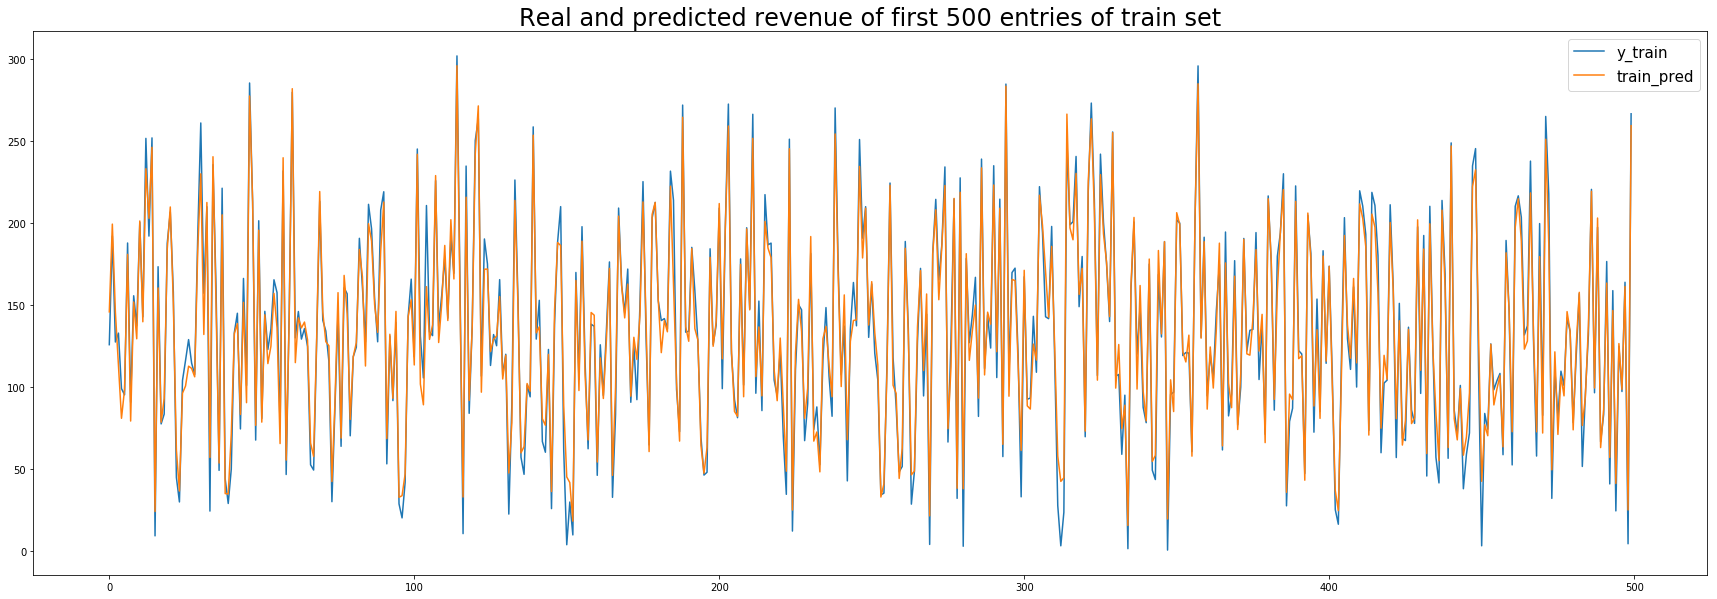

In [44]:
plt.figure(figsize=(30,10))
plt.plot(y_train[:500],label="y_train")
plt.plot(train_pred[:500],label="train_pred")
plt.legend(fontsize=15)
plt.title("Real and predicted revenue of first 500 entries of train set",fontsize=24)
plt.show()

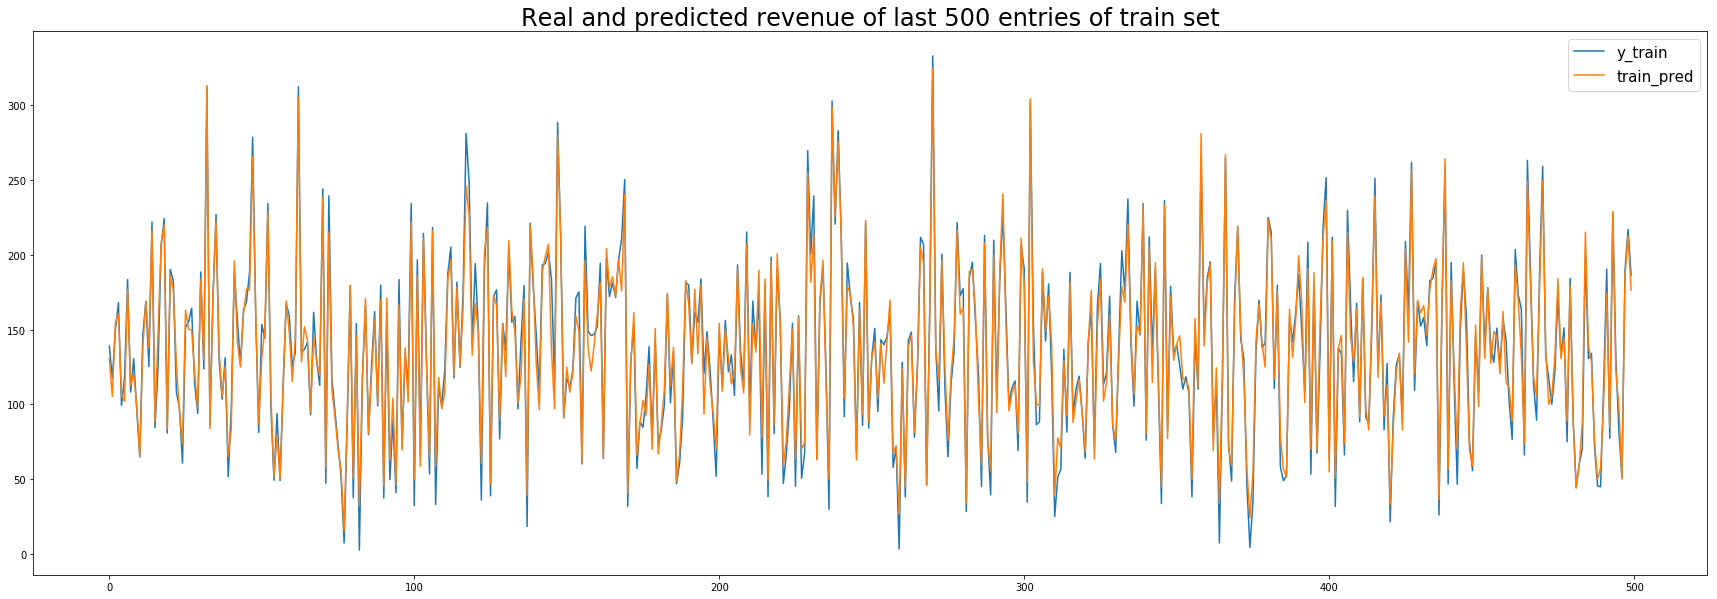

In [45]:
plt.figure(figsize=(30,10))
plt.plot(y_train.values[-500:],label="y_train")
plt.plot(train_pred[-500:],label="train_pred")
plt.legend(fontsize=15)
plt.title("Real and predicted revenue of last 500 entries of train set",fontsize=24)
plt.show()

## Part 2.3: Make the predictions and write them to the submission form

In [46]:
lgb_pred=model_lgb.predict(test)
xgb_pred=model_xgb.predict(test.values)
cat_pred=model_cat.predict(test)

When computing the predictions we must remember to apply the inverse of the tranformation we applied on *y_train* in Part 1.1

In [47]:
pred=inv_boxcox1p((xgb_pred*c[0]+lgb_pred*c[1]+cat_pred*c[2]),0.2)

sub=pd.DataFrame({"id":np.arange(test.shape[0])+3001,"revenue":pred})
sub.to_csv("my_submission.csv",index=False)